# Simple Agumentation  for bounding box

(1080, 1920, 3)
BB 0: (180.0000, 60.0000, 1734.0000, 1035.0000) -> (541.1841, 317.5725, 1454.8761, 890.8349)
BB 1: (1216.0000, 667.0000, 1475.0000, 845.0000) -> (1150.3121, 674.4651, 1302.5941, 779.1222)
(1150, 674, 1302, 779) (1216, 667, 1475, 845)


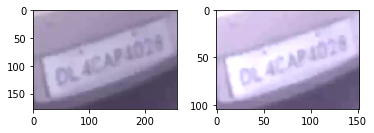

In [63]:
import imgaug as ia
from imgaug import augmenters as iaa
import os,sys
import cv2
import numpy as np
# from matplotlib.pyplot import plt
import matplotlib.pyplot as plt
%matplotlib inline


ia.seed(1)
image = cv2.imread('/home/gpu-machine/labelled-data-new/Station1/augim.jpg',1)
print(image.shape)
#image = ia.quokka(size=(256, 256))

#sys.exit(type(image))

#180 60 1634 1035
#1216 667 1475 845
bbs = ia.BoundingBoxesOnImage([
    ia.BoundingBox(x1=180, y1=60, x2=1734, y2=1035),
    ia.BoundingBox(x1=1216, y1=667, x2=1475, y2=845)
], shape=image.shape)

seq = iaa.Sequential([
    iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
    iaa.Affine(
        translate_px={"x": 40, "y": 60},
        scale=(0.5, 0.7)
    ) # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
])

# Make our sequence deterministic.
# We can now apply it to the image and then to the BBs and it will
# lead to the same augmentations.
# IMPORTANT: Call this once PER BATCH, otherwise you will always get the
# exactly same augmentations for every batch!
seq_det = seq.to_deterministic()

# Augment BBs and images.
# As we only have one image and list of BBs, we use
# [image] and [bbs] to turn both into lists (batches) for the
# functions and then [0] to reverse that. In a real experiment, your
# variables would likely already be lists.
image_aug = seq_det.augment_images([image])[0]
bbs_aug = seq_det.augment_bounding_boxes([bbs])[0]

# print coordinates before/after augmentation (see below)
# use .x1_int, .y_int, ... to get integer coordinates
for i in range(len(bbs.bounding_boxes)):
    before = bbs.bounding_boxes[i]
    after = bbs_aug.bounding_boxes[i]
    print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
        i,
        before.x1, before.y1, before.x2, before.y2,
        after.x1, after.y1, after.x2, after.y2)
    )
    b=(before.x1, before.y1, before.x2, before.y2)
    a=(int(after.x1), int(after.y1), int(after.x2), int(after.y2))
# image with BBs before/after augmentation (shown below)
#plt.figure(1)
image_before = bbs.draw_on_image(image, thickness=2)
image_after = bbs_aug.draw_on_image(image_aug, thickness=2, color=[0, 0, 255])
#imshow(image[60:1080,180:1734])
print(a,b)
plt.subplot(221)
plt.imshow(image[b[1]:b[3],b[0]:b[2]])
plt.subplot(222)
plt.imshow(image_aug[a[1]:a[3],a[0]:a[2]])


#  Shifting/Moving Bounding Boxes

In [ ]:
import imgaug as ia
from imgaug import augmenters as iaa
import os,sys
import cv2
import numpy as np
# from matplotlib.pyplot import plt
import matplotlib.pyplot as plt
%matplotlib inline


ia.seed(1)
image = cv2.imread('/home/gpu-machine/labelled-data-new/Station1/augim.jpg',1)
print(image.shape)
#image = ia.quokka(size=(256, 256))

#sys.exit(type(image))

#180 60 1634 1035
#1216 667 1475 845
bbs = ia.BoundingBoxesOnImage([
    ia.BoundingBox(x1=180, y1=60, x2=1734, y2=1035),
    ia.BoundingBox(x1=1216, y1=667, x2=1475, y2=845)
], shape=image.shape)

# Move both BBs 25px to the right and the second BB 25px down
bbs_shifted = bbs.shift(left=25)
bbs_shifted.bounding_boxes[1] = bbs_shifted.bounding_boxes[1].shift(top=25)

# print coordinates before/after augmentation (see below)
# use .x1_int, .y_int, ... to get integer coordinates
for i in range(len(bbs.bounding_boxes)):
    before = bbs.bounding_boxes[i]
    after = bbs_shifted.bounding_boxes[i]
    print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
        i,
        before.x1, before.y1, before.x2, before.y2,
        after.x1, after.y1, after.x2, after.y2)
    )
    b=(before.x1, before.y1, before.x2, before.y2)
    a=(int(after.x1), int(after.y1), int(after.x2), int(after.y2))

# Draw images before/after moving BBs
image = bbs.draw_on_image(image, color=[0, 255, 0], thickness=2, alpha=0.75)
image_aug = bbs_shifted.draw_on_image(bbs_shifted, color=[0, 0, 255], thickness=2, alpha=0.75)

print(a,b)
plt.subplot(221)
plt.imshow(image[b[1]:b[3],b[0]:b[2]])
plt.subplot(222)
plt.imshow(image_aug[a[1]:a[3],a[0]:a[2]])

# Augumenation for classifacrion

In [19]:
import imgaug as ia
from imgaug import augmenters as iaa
import os,sys
import cv2
import numpy as np
# from matplotlib.pyplot import plt
import matplotlib.pyplot as plt
%matplotlib inline


ia.seed(1)
imag = cv2.imread('/home/gpu-machine/projects/dataset/crop_rnpd_image_dataset_3477/set9_fea4d0e2aa5345b387e170873a57fc01.jpg',1)
print(image.shape)

images = np.array(
    [imag for _ in range(32)],
    dtype=np.uint8
)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

images_aug = seq.augment_images(images)


(1080, 1920, 3)


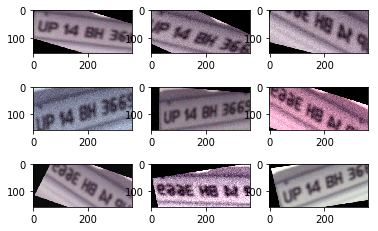

In [22]:
plt.subplot(221)
plt.imshow(imag)
plt.subplot(322)
k=1
for i in range(20,29):
    plt.subplot(int("33"+str(k)))
    plt.imshow(images_aug[i])
    k=k+1

# Heavy Augmentations

In [9]:
import imgaug as ia
from imgaug import augmenters as iaa
import os,sys
import cv2
import numpy as np
import pandas as pd
# from matplotlib.pyplot import plt
import matplotlib.pyplot as plt
%matplotlib inline

def augmentation(impath):
    ia.seed(1)
    imag = cv2.imread(impath,1)
    #print(image.shape)

    images = np.array(
        [imag for _ in range(32)],
        dtype=np.uint8
    )

    # Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
    # e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second
    # image.
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    # Define our sequence of augmentation steps that will be applied to every image.
    seq = iaa.Sequential(
        [
            #
            # Apply the following augmenters to most images.
            #
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images

            # crop some of the images by 0-10% of their height/width
            sometimes(iaa.Crop(percent=(0, 0.1))),

            # Apply affine transformations to some of the images
            # - scale to 80-120% of image height/width (each axis independently)
            # - translate by -20 to +20 relative to height/width (per axis)
            # - rotate by -45 to +45 degrees
            # - shear by -16 to +16 degrees
            # - order: use nearest neighbour or bilinear interpolation (fast)
            # - mode: use any available mode to fill newly created pixels
            #         see API or scikit-image for which modes are available
            # - cval: if the mode is constant, then use a random brightness
            #         for the newly created pixels (e.g. sometimes black,
            #         sometimes white)
            sometimes(iaa.Affine(
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                rotate=(-45, 45),
                shear=(-16, 16),
                order=[0, 1],
                cval=(0, 255),
                mode=ia.ALL
            )),

            #
            # Execute 0 to 5 of the following (less important) augmenters per
            # image. Don't execute all of them, as that would often be way too
            # strong.
            #
            iaa.SomeOf((0, 5),
                [
                    # Convert some images into their superpixel representation,
                    # sample between 20 and 200 superpixels per image, but do
                    # not replace all superpixels with their average, only
                    # some of them (p_replace).
                    sometimes(
                        iaa.Superpixels(
                            p_replace=(0, 1.0),
                            n_segments=(20, 200)
                        )
                    ),

                    # Blur each image with varying strength using
                    # gaussian blur (sigma between 0 and 3.0),
                    # average/uniform blur (kernel size between 2x2 and 7x7)
                    # median blur (kernel size between 3x3 and 11x11).
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 3.0)),
                        iaa.AverageBlur(k=(2, 7)),
                        iaa.MedianBlur(k=(3, 11)),
                    ]),

                    # Sharpen each image, overlay the result with the original
                    # image using an alpha between 0 (no sharpening) and 1
                    # (full sharpening effect).
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

                    # Same as sharpen, but for an embossing effect.
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),

                    # Search in some images either for all edges or for
                    # directed edges. These edges are then marked in a black
                    # and white image and overlayed with the original image
                    # using an alpha of 0 to 0.7.
                    sometimes(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0, 0.7)),
                        iaa.DirectedEdgeDetect(
                            alpha=(0, 0.7), direction=(0.0, 1.0)
                        ),
                    ])),

                    # Add gaussian noise to some images.
                    # In 50% of these cases, the noise is randomly sampled per
                    # channel and pixel.
                    # In the other 50% of all cases it is sampled once per
                    # pixel (i.e. brightness change).
                    iaa.AdditiveGaussianNoise(
                        loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                    ),

                    # Either drop randomly 1 to 10% of all pixels (i.e. set
                    # them to black) or drop them on an image with 2-5% percent
                    # of the original size, leading to large dropped
                    # rectangles.
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.1), per_channel=0.5),
                        iaa.CoarseDropout(
                            (0.03, 0.15), size_percent=(0.02, 0.05),
                            per_channel=0.2
                        ),
                    ]),

                    # Invert each image's chanell with 5% probability.
                    # This sets each pixel value v to 255-v.
                    iaa.Invert(0.05, per_channel=True), # invert color channels

                    # Add a value of -10 to 10 to each pixel.
                    iaa.Add((-10, 10), per_channel=0.5),

                    # Change brightness of images (50-150% of original value).
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),

                    # Improve or worsen the contrast of images.
                    iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),

                    # Convert each image to grayscale and then overlay the
                    # result with the original with random alpha. I.e. remove
                    # colors with varying strengths.
                    iaa.Grayscale(alpha=(0.0, 1.0)),

                    # In some images move pixels locally around (with random
                    # strengths).
                    sometimes(
                        iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                    ),

                    # In some images distort local areas with varying strength.
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))
                ],
                # do all of the above augmentations in random order
                random_order=True
            )
        ],
        # do all of the above augmentations in random order
        random_order=True
    )

    images_aug = seq.augment_images(images)
    return images_aug


In [11]:
images_aug=augmentation("/home/gpu-machine/projects/dataset/crop_rnpd_image_dataset_3477/set9_fea4d0e2aa5345b387e170873a57fc01.jpg")

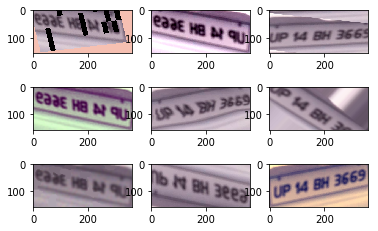

In [13]:
#plt.subplot(221)
#plt.imshow(imag)
plt.subplot(322)
k=1
for i in range(1,10):
    plt.subplot(int("33"+str(k)))
    plt.imshow(images_aug[i])
    k=k+1

In [30]:
from PIL import Image
import glob
from shutil import copyfile
import pandas as pd



label_csv="aug_label.csv"
label_dict={}
im_path="/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/"
save_path="/home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/"
count=0
aug_count=0
label_list=glob.glob("/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_np_label/*.label")
for lb in label_list:
    filename=lb.split("/")[-1].split(".")[0]
    print(filename,"  "+str(count))
    input_im=im_path+filename+".jpg"
    #print(input_im)
    try:
        image_augs=augmentation(input_im)
        count=count+1
    except:
        continue
    
    
    with open(lb,'r') as lf:
        content=lf.readlines()
        print(content[0].strip().lower().replace(" ", ""))
        text_label=content[0].strip().lower().replace(" ", "")
        for i in range(len(image_augs)):
            save_p=save_path+filename+"_aug_"+str(i)+".jpg"
            #print(save_p)
            label_dict[filename+"_aug_"+str(i)+".jpg"]=text_label
            #print(label_dict)
            im = Image.fromarray(image_augs[i])
            im.save(save_p)
            aug_count=aug_count+1
            
df = pd.DataFrame.from_dict(label_dict, orient="index")
df.to_csv(label_csv)
            

1_390213b722f34fd5b4446304e5710d43   0
dl7cl2987
set1_be60492c7c664d9293aeafee9907101f   1
up16ap3653
7_a9c605b298ee4616b36b5db537012582   2
dl2caa3541
9_df8b4247883d41a6ab12eb3b50678082   3
up16u3588
set11_292ce10b43f944b294021a5f42378ac9   4
up14bj1100
set11_0c79f06bdf0c4f178315ec3bd685c794   5
up13aj0050
set5_87eaa258b83946b381a80b2c03186452   6
dl13cc4644
2Station_2_New_d8d025d04fbb4c99b69484dea055052d   7
up16bc0299
3Station_2_New_a80f7050ecb549aa92f1434d64a1fa1f   8
up15w8472
14_091eb014c2294030a0fbcab326f3336e   9
dl5cj8396d
10_6ae2729f752943b1b14c8705a6c9b14f   10
uk04m0480d
13_4a7a97293c69444bb278fc703e1d39ca   11
dl8caa9693
3Station_2_New_1668502954c3419f8d7414ceeb4b42e9   12
up16ay5604
1_17b9b9e066b64fcd9ac7f7160acf4168   13
dl8caa9693
frame241   14
mp07cb3200
1_aafaaa0b5bee4184944817a512f5f019   15
dl8caa9693
3Station_2_New_467faf8c336b4b0b846ec379f8da16b0   16
dl5ck8799
7_2f95fbffdbe240b3a04a60b151f767ed   17
up16v7208
2_bfdbaff048624a84b8c0f0a339d41a19   18
hr70c6346
1_64

hr26be6544
set12_45a005e3825a411aab32d00ae9914d72   154
up16ap4344
12_f3fb4449c6b94ff280a2cc5788131562   155
dl4cnc9308
12_5c557d9254684ecfa0bbf66e8b587711   156
d
3Station_2_New_22b375fab2f3493f86ea5b7fad46c7e3   157
uk08z7777
5_fb445d5a82d1463b82872d8d75e0e3eb   158
up16bc1102
3Station_2_New_eb6d3ec39089415596f8b41582624eb3   159
hr26cm1437
1_3b74a9e2ba314c08a5ff83b9d42f423a   160
mh02dn8046
set1_994c2051a4f74ba18245abfd069e9dd1   161
up16an9625
set12_cdaa354d7ddc4871a90c6152131298cc   162
dl7ce6110
frame71   163
hr26c09598
4_cdbab574563442028ce2887a9e3c66ec   164
mh02c09915
1_11d034bc1d924ce697b85d2b0d4a2979   165
up16xd7878
7_2705b702be2e4e5c84b2314e4ddb2214   166
up16ar6988
6_aaa07f056d434390bfbac119af66ba0b   167
up168v7600
6_f9b62394b7fe495c8c07396f0d3a81f8   168
up16aa3228
1Station_2_New_340f6b374f2a43e6a00cf7acb263a209   169
dl9cq9812
2Station_2_New_4abd2397d9e1436aae7bb43313d82517   170
hr29ac9488
5_46f2e8cfb77d4fa3b73d4c225e36f6cc   171
up16ar6042
1_8be86165c8be44fdae21efa1f

up16ay7263
1_ab434e9e49534205ac8f9f026719815b   309
uk04m0480
set2_17bcef54856c44858525157a7e40e113   310
hr26en9685
15_57fcab009106442c82335904a69ca782   311
up37c4160
frame292   312
dl9cac6377
frame500   313
dl1cv0393
set8_f77b47104b6a42cbb4d8d467c4962948   314
up16am9258
7_46688fd4ffb84377a467be89c4d01892   315
up16ac0987
3Station_2_New_65d315ab6fa64c79b87f0e875d8d5686   316
up13aj2007
1_669b46cb6dfb4c35aca605d52fe79ef9   317
hr51ay0004
set9_f32fb953bef342aaa60d4ae03d2739f2   318
up75m9641
7_46aa7c7f2697466aaf36657cc3b356e4   319
up16am7908
3_73cd1c7016b344fe87012d0b400cda11   320
up140k0446
11_c4a5b28f3e7746cb85bc0ce18954be2e   321
dl5ck8799d
set3_c0bd7317ce234d168383b1dd15239311   322
dl3cbm2073
3Station_2_New_a793f6c3f9fd40a893c32a84e343204e   323
up16q5920
4Station_2_New_89e7901bfc4441b2a8567de856d17e2e   324
up16ap5610
3_743aa059bbf4446098618403bb828105   325
up14cl2968
set3_3be0078e164d4e0e9c0930c8cd76c793   326
dl3cbm2073
frame485   327
dl1cv0393
9_903f81f3a4444ca381d1068b1cd

dl8caa3516
set12_588276ca8701464e84156c8d0c9b374e   465
dl2cau1727
3Station_2_New_1338bc46693f45b7b9952e0911f690b3   466
up16aa3228
set12_e987a1e877c1420da0fdc17727a84736   467
dl7ce6110
1_5495f31c4f0e4c5aa01fcb3ce81fbd85   468
dl3c8p8136
7_176af0eb9c1a46afb456990f083c42d5   469
dl8caa3516
1Station_2_New_187315856ade48fab37d95d14f39c37c   470
dl7cg9850
set1_5825559ab2ff41259269ddbe14940892   471
up16et8462
1Station_2_New_b9540a3aaf4b4b9d8f9543fe88001904   472
hr26bk9240
1_429676c9a41c47d985c343eb6eefd188   473
hr519a7529
set5_314241e1bcc041649b2d0f8ae4d1387d   474
up16az7328
1_30cc01a13d8446528f89a5726f257839   475
hr519a7529
13_593e823ddcbb4c77b270c61717386d94   476
uk04m0480
8_10dfcdc4e4434748804a5a24b846715f   477
up16ay7474
4_060ceb896b934d8daba0c74a13d701dc   478
up16ba0048
set1_e52dceb31fcf44b6a6846c543899e5d6   479
up16bt6915
14_a645194f9ba0412a900e7934f95b4be7   480
d
set11_764005037e28489b83e283e8d0dd475a   481
up81ay6986
8_43e2245b2d4249e583de5c8c3d067209   482
up16ac0097
13_

dl3cbp6136
5_295cb94bb02f4324b5b6bcd0a8e8508f   619
dl3cbr9777
11_0330f40ab80043a495a57219624481eb   620
d
set9_f080d4e6e4884da3ab6dbec5ec158ea6   621
nho2009915
4Station_2_New_cccfeaf1e53046d394460ac942c439b8   622
hr29x5503
14_a805bc3077014664b087c6cd1b811304   623
hr72b0863d
13_5d380c8f4785480fb090e90ee36206c0   624
up16am2788
4Station_2_New_9cf723f4c62a4c52922be226237ba037   625
up16ak4769
set3_12266a31a8d74635a88bd2d8fd1bb8d6   626
up16ap5152
3_66b8dcee704e4e3596b7ca7a1ebbad20   627
up140k0446
set1_3e549c081cac47e9a88521c7f79a6c09   628
up16z3309
4Station_2_New_e28f66d3ca4b4b0796a2a27062aad58f   629
up16bb0729
set4_466fc034b85e4041bbd4648183bab504   630
up37a4870
3Station_2_New_4d5a95c04b3e457a8388fb6b5221256d   631
dl5ck2230
1_8ce933fc71c241a1bb2bff2e8659c89e   632
up14bp5070
3Station_2_New_0c7221ec758642689050e8b86b5da1e2   633
hr268v1905
3_eb37730ec346473fafffa73da5551644   634
dl8caa3516
8_ec09652142ac4231adafc4d1b14f8a4a   635
dl10cs2904
7_4775a9fa6ed5470b93594c02ce96eb3b   6

dl12cc9004
13_84073157424a40bdb6e8a498cd4af186   775
dl5cj1331
8_aeaccdd80fdd4b89ae0d0454e0371319   776
up16x9639d
6_e5c66768941b47caa14eccce4807b5eb   777
up16x9639
4Station_2_New_f8306bba4da24c2c80e7fc19e5e5cbc6   778
up16am4321
7_2ae740c0a0554f4a83a96ddf9db8d226   779
up16v7208
set12_31f33b09f5e24c1c9ecfb282a0d17fcf   780
up16w2893
15_4cecd1fd4b8443da8f63f2d4ba5d43aa   781
dl5cj9113
11_8a4f1aee431341a6b522437d864a9255   782
dl4caf8389
4Station_2_New_bfb286871bcf4cb7a07fda725d9d4f8d   783
up16ct6500
set9_2af57477baba4862b0ed4848221a6b28   784
up16dt7925
set2_d52a2681589b482f918a7bd0120f0aca   785
up16bu8036
frame370   786
dl10cs7303
8_9e87f698295642bbb241f17a27ac9748   787
dl2cad84
14_94443e7b922949cca0348bd3296c6334   788
dl7cg9850d
set4_804042b2268a4ecea208991371ec29bf   789
dl3cc83686
set8_833006bb3d2c48218d6e3c04f5a21cc4   790
dl5ck8799
7_9b4d513ba0b346bb89d2e1932192d2b5   791
up1be9825d
set1_2e66c1d75eb744ebab5ce6ab19b7a6a2   792
up16z3309
12_2ef82b3e08684d898e4c79318a0b2e38   7

up16x9639d
4Station_2_New_04ea80783aaa4726a1bd6327e6d915e6   928
hr36ac8105
12_f2c3e62a258743d98e0b0577753f2737   929
hr77b8379
3_b28366735d5f4d32bf9a5484ef26419c   930
hr51az8136
15_c7b561ac45304a778b26ce580fef4eb9   931
dl6cp7135
13_a19988c4bd03402f9a947cbede33a96b   932
dl14cb0944
7_c77f50e76bd04c79819227b46487af39   933
up16rt6473
set9_7e6a1a8c379343deb4c240e836b873a0   934
up16dt5773
set1_b99fc288daf44423af89cf3976d03023   935
up16be9825
4_dd7ea08f8f154a41a69d88eb41d69bf9   936
up16ap6858
3_820488e7d0564aeeb3f04b65cf2bc2e1   937
up16av1197
set11_cd86c24616a44de9927ca8b7a58f648b   938
up16bb9791
set12_de80ae82f653415fb27ac76347fca6bb   939
up16av7189
7_98b80be2519241c583c8864e6b66a6c6   940
up16rt6473
13_703090e27f6247adaeeebb9aa9ce9c4b   941
up75m9641
13_96b8c271395e4840805a945b5730e006   942
dl3cbq2355
9_6e008bacd249473fae29c1c98392f309   943
up16ah7908
14_6097b3e381584dee9644cd9998115c73   944
up16w2893d
set9_878ca389e3f44ffa9c20925d22799ded   945
dl6cl4970
4_f420f167400e41b89b6

dl8caa3516
12_c3122503e65c4328a4622e8c0276dfd3   1080
rj20ca7501
set12_eac3592e530e43989cd0fe5a1d98e36c   1081
dl2cay4696
set2_edaeeabc24e14e70a637f314668f00ec   1082
up16ba4570
2Station_2_New_6a930686702041ae85d1828548edf1b2   1083
up16aa3220
1_84818083888d4768a445cd5f15ec878b   1084
hr26cc0809
12_b8d21e71dab443e6860292bb64dd61f1   1085
dl8ct7748d
12_f1ed528b7edf4c6b8f78cc49b9709249   1086
hr26dl1771
15_d71b5f5ad2d24aff92b990f4d39eeee0   1087
up14cl2968
4_5b26dbd35a1644f281b816143a3da380   1088
up16bu6450
15_443616ba33c841efbdd561d674f94dca   1089
dl6ce8179
3Station_2_New_e1045f9045074087b8d045dfe1b01378   1090
up16ay6400
frame769   1091
hr26df4063
7_4092014cfef241dab05e45dc831c8456   1092
up16v7208d
set3_6eec4c0e3ac54297a04a7b1587427be5   1093
dl4cae4195
2_cb59527d59b446d0ac56bb1a3bb59411   1094
hr70c6346
2_ce7fda2d47b749a18984d84c8f1b183a   1095
hr51ak2193
15_6dbe9afe0cfb4a52b4ba47c299394260   1096
up16be5142
3_84d8ed2b96de4a948f6efb4730e35af1   1097
up16ap5152
1Station_2_New_0ba662

up16av1197
4_29fdde56f77c42d0b48e286791fa96e4   1233
up166n0345
3_f057dcd875834c62af66b48bed49facc   1234
hr26cm1437
3Station_2_New_1ceee5ed522a4391b367237eaacb0beb   1235
up16q5920
set3_a6ff5bcca0e444eb97a4750f31bc9f22   1236
dl3cbq2355
4_488f74bb61904edca475e63a507c9baf   1237
up16ap6858
5_4721a332ecef46c39f7d3efa9236ffeb   1238
up16801600
15_46f8eb464bff4bf59e5efa5de88b83fc   1239
dl8ck6805
1Station_2_New_818e18cb3cca49dc9fe8fe6cc0790759   1240
dl8cae8471
1_5289c6235d8e415ba31d326d09da3c39   1241
rj14ch6823
set3_1513835bb6314940b5f5448951cfc8d1   1242
up14dk0446
set4_ee6f54a2063b481b8018776bce6ae929   1243
mh02cd9915
10_18a5e17c771d48ee85ffdbc11e4ab0f7   1244
up16ap3653
15_e319dd584bf04406b4d7f0169a237301   1245
up16aa3228
14_de0ad66ec5a641b7add38a387e3f6fee   1246
d
4Station_2_New_ad2fb7ce48e8484184b3e880f02e556d   1247
up16ct6500
set5_11faf922fb7c4821848e44417d9b31ff   1248
up16bc1102
12_ddf7847e37f44abdbd124dba64f207fc   1249
hr72d7122
1Station_2_New_ce7caebd5bf746ef855489f6f60c7

up16am4321
11_383fc6e969394e95b1161a5541963d6e   1383
d
1Station_2_New_f4a3c0541e344a8fa66e3032ccb2721b   1384
up14dt5978
1_981378081af440ed99e96785dd5d6e73   1385
up16dt9346
2Station_2_New_c5a5ba7dc3844005b4463464a2f37cd3   1386
up16bc0299
12_b4be36bc38d74040bd2e4f0d351bd6e7   1387
hr26cc0809
15_32407696824145fb9d2407b3e6271527   1388
up16bt5556
4Station_2_New_86dc76913723467db93e3b030fc3dfa6   1389
up16ct6500
12_78add01b19dc41b48abe0cd8f1986371   1390
mh43aj4183
3Station_2_New_d307c99fc67342ce89456d3402affff4   1391
uk08z7777
15_59adedfcd30e4c36adf7a026c28db236   1392
up20ad1112
15_7a65f152300a46cdb2d9433015f08bca   1393
up16be5142
set4_c53bdcb94a1c47968470d08bc3f5dd66   1394
up14af1081
4Station_2_New_d69c0f2a59f2458984663b3ce71c0553   1395
up16ct6500
set1_617a0962e97f4bb5bd0077c2a3ccbc0d   1396
up16bt6915
frame581   1397
dl2cz5393
2_6afe4d8b345d4ee182f4ecd071622567   1398
rj20ca7501
10_0aa149785393455eb4b356d517d0a7b0   1399
d
15_ebd847bd29ce4d839f2c8d0cfdec6e32   1400
dl9cq9812
set

up16dt4631
13_af7c332cd4c249f197d2738259e96500   1535
dl4caf8809
4Station_2_New_e44f52c8625642ab85ba004892bfe5bf   1536
hr51ak9277
set4_6cffdfa6750844b19c74e6677814db3a   1537
up16ad2887
13_6c9f9cdd71c2462db3ed09578c291392   1538
dl8caa9693
15_8d346de126104f1b93dd0e4b16a8fa79   1539
up16et6473
9_d2a31e690f7c4a7eb8cfe6e47c4d9c1c   1540
up16ah7908
set11_b1659cff0a9c47e693d4298c59f0c423   1541
up16ar3136
3Station_2_New_87f354d3b8ed427188a5a707ba5ef084   1542
dl8caa9693
1Station_2_New_514ccf3cc4d849a59fd67d19af77ef20   1543
rj14ch6873
1_c5cf3dc81f7a413fae449be1957870e5   1544
dl8cae0848
set11_f4e03ac4c0e2432da1438bbdb859201b   1545
up16as2605
8_4162ac52fb59405392f4d8d5076f4d34   1546
dl10cs2904
frame602   1547
dl1na1003
1Station_2_New_dd3de56a349c43199d7eed9aea6785bd   1548
up16am8861
7_eedecb4fab3d4eae8f4526107f5d3df1   1549
up1be9825
3Station_2_New_ace3c8eb7ef2443ca887bdf8425f2eb8   1550
up16ct6500
set4_560ab229b1a34b3c9218cba66581102f   1551
up16ad2887
5_8585597f6e6c4840a5ccd232af1b6718

up16al5109
2Station_2_New_90ad9d43f1ec44d9a9dd6bbaf10c4a6d   1688
up16ay7484
set2_bfe223c73e674f9fb829dc04b1bba702   1689
up75at1903
frame677   1690
ka51mb0345
set12_2072ae24ad744502b0f2200c24573f68   1691
up16ct6500
set8_56a6274d46d1460fad20809aeaf88903   1692
up14dt5978
set11_a93ffa583b79480a8be5f1e9493f2631   1693
dl8caa9693
9_a524241aeaff42798d51aa80bfe105c4   1694
dl3cat5500
2_3b9fe425d28b492ea573fe494adf0f9a   1695
uk08ac2276
5_8b2f4fbe2c4f4478a760411d2171110c   1696
mh05ab3050
set8_ab33c67a534b4197a2d94d912a8687b6   1697
dl2cad84
4_efad2e74cd0b41749356a2a709fd339f   1698
up3cc83686
3Station_2_New_8c8d5f03666b4756831425ae5316ca3f   1699
up15w8472
13_fd0c497ca9c84653be3a41ac2a5d204e   1700
up16am7908
15_8c60110f22b74aac99b8fae6ec89f775   1701
dl8caa3516
3Station_2_New_514aaed235404010bda6e5326117565c   1702
up16dt5775
8_99fff4f6530a43c6863f76d5a3189cbb   1703
up16an1133
15_b75064c919b54289a2f8ae79497188e2   1704
dl5cj9113
set9_d763d1cb844c4992adb48f43841babcd   1705
uk08z7777
7_fa

hr51ay0004
frame191   1839
hr26cg34448
6_955bf2d694a84b6cbe9d9ad42125fb98   1840
up14bt4651
frame738   1841
hr51u1810
10_3886330e73fe4c149e849ef2af7e31c6   1842
d
set9_cea43bd11dd94b2c89220712a1578450   1843
up16dt8611
3Station_2_New_6261edb04a9b4e7dbaeb1d83b3ebc5c6   1844
dl7cd9201
2Station_2_New_b575809be7c743e2b9727d20d87eadef   1845
up16ac3450
1_aadd2c2362e64bf9896232382e8bcb78   1846
dl3cbp6136
4Station_2_New_4172985a37e642efa6c9e28127f05ae3   1847
up16ct6500
7_f78197e9a01d494c8424f17c5015d389   1848
up16ay5386
2Station_2_New_2eaadc3555e6436895a9903cb89513bb   1849
up16rs0068
1Station_2_New_c55156db1a1646828447368a330a2b8b   1850
hr26bk9240
9_190fb77690224ed8bdc47026d4badc9d   1851
up16et8462
1Station_2_New_44fad25c2b7e44e28c7600ec2bee91d4   1852
up16ay7263
6_0b0d236342454791b7de7948c289160b   1853
dlbcaa3516
14_ae1a85e4f0a94b18b61f6a08fb130517   1854
dl12cc9004
set4_a0319a3f7ef04db6b1d7e762240ceb63   1855
up16ah8700
4_3804e43c10fb4eafadcf6fe70c899fee   1856
hr26bs2192
frame882   

hr30p3500
set1_cf98e7095cdf4067ba1c6baee688dfdb   1991
up16an9625
7_ce72b4842b7340019795f162dff177c8   1992
up16ay5386
frame620   1993
hr20ad1347
set3_6b8686e219234a8fbdbeba285336a860   1994
up16av1197
3Station_2_New_aca18125ddf144c8ab4ace41ef40d94a   1995
dl5ck2230
15_d0d9a1c3f2664c3cbf347c3cce5d613d   1996
mh02cg9915
6_dfffd896cc0f4f2ea773b48f168055b7   1997
up16ax2979
1_a6a4e8c0a4a7412c839fa1ab58b3e56c   1998
up16z3309
frame672   1999
ka51mb0345
set12_d7c65180ef14495d808907de0be7acd7   2000
dlbcaa356
frame703   2001
hr26bq5724
1Station_2_New_d4cd777d9e7e4627bcdd6d26bb66c24d   2002
up83ah4899
11_8b6714f9ad58487cb6556aac8e1a18ac   2003
up16a4477d
frame422   2004
hr479693
frame599   2005
dl1na1003
3_7d9573e5370b452cb284dce4fceed3c7   2006
up16z3309
frame575   2007
hr20ad1347
1_4aae9582cbf44e929814ff8c230c1fe5   2008
hr51ay0004
set3_9753cc083b50486ea25aa385934b598f   2009
mh02cd9915
set1_87c227da4b644896a9b26091a503e91b   2010
dl7cl2105
13_807efaf40701497e9d20642d1a827b00   2011
up16ac3

hr26bs2192
7_016aa5b8f5544d1182a185e4a477fda2   2147
up16bb9791
12_5deea5975d92421a81dc99133bf89edf   2148
ch01as3275
11_0494cb6a0bcc4f0083e9dc33ce774edc   2149
d
5_66da976857ca47a186ccd6562332fd7c   2150
dl9cab9705
set3_dd6773b4e51143398e32e4b8790b9eae   2151
uk08z7777
12_c5e6354e195346cd996b62d5e8ddadf4   2152
dl7cl2987
6_5369e01a57a54c47bb3fce914480500e   2153
up16v7208
set4_3b9a30eae10d4806bbbc040c6881baab   2154
up16an2232
15_7131939261c84f15b1fea5e084600828   2155
dl8ck6805
15_4bd0764a78414261a2f7b81a9a28506f   2156
up16al3340
frame243   2157
mp07cb3200
4Station_2_New_dfda2a3d7fab44fa86de89429488f99c   2158
dl8ct7748
set12_fa0845ce86eb4322adb96da0f8209b96   2159
up75at1903
15_505a55c1defd459f80a689ae8e2827ea   2160
up16be5142
7_a97544dda36a48bf8f1231772abe79cf   2161
dl12cc9004
15_3ffb61a566f04851aff1f8656c2eeb7c   2162
up16av8173
4_5a97b0359bb749baa70c4217435b4f85   2163
uk07at9089
12_fb420398774e485ea619ee535676d0b8   2164
hr26cc0809
set1_9561c514be3142f3bb5b8f50dabbaa43   2165

hr51bd4717
1_ecd40a3b58884e169accc5b46b66bcfc   2300
mh43aj4183
1Station_2_New_35e4d1ac85814e34b2343cb65e30bdec   2301
dl13cc4644
set11_96b314345ff943108486bce2b2f72413   2302
dl5ck8799
set4_36bfc2ce736340aa84f064b9ed665744   2303
uk07at9089
set11_aadbaebee7ff4ce3b3e64b0a2023ba6f   2304
up79t5958
2_abb8c0bd3f734bf79a07804bc9081a3f   2305
hr61a8748
4Station_2_New_61e91c0a677a49afb0445e4090e353f8   2306
up16dt9346
2_8418c28c96be47fc9276d5f80021739a   2307
up14ct2287
10_d9fcc724ae1b445181e6ba087780abcf   2308
d
set9_ea6f3c2ad27d49f4a6b7dc808b566a46   2309
up14bh3669
set3_bd86c34f48c643dda8662756b2044f69   2310
hr51az8136
set2_a3949f901ee14275902890baeec16ac7   2311
up12x1463
set5_08cb7825fba84fe4b31dc72761a162bc   2312
mh05ab3050
7_e94355dff52e4040add9bbd05c20743c   2313
dl3c8p6136
frame7   2314
dl12c0327
6_2f4ee285f5ab40a9b7b9553e5d31ae92   2315
up16ax2979
6_7f0e54796cfd4f2fb2b7ce1a7da90730   2316
up16as7978
5_06dd7938b2b24910bce57f212f50e920   2317
up16ah9020
set11_6b10f1811aff40489ff0d

up16ay5604
7_8cfb59c5e75749388d8ea984946c1662   2449
up1be9825d
7_3ff65df3c7644470bf700eca5724e917   2450
up16bs8740
set8_948ea4b7cb73483f925b382671ba62e4   2451
up16at8012
10_94ce4249a456413aa9816af00c45d9b5   2452
up16as2605
15_44f325cb86224b0ba9db7907cbb99742   2453
up16av8173
5_3fc246528fbf474ba14d2387de6c23e7   2454
up16ak1637
3Station_2_New_b06a70e4547f494696aa337aa65067a4   2455
up16af7086
2_6b13c67341a24941bc4236abe5b8e4bd   2456
up75at1903
set2_211caf43e15647a38e552f2b0fed78f7   2457
up16bu8036
4_6da877e750874575bc761d5651718906   2458
mh02c09915
8_65c3d1bd39794bdda29701a303dd5f4f   2459
d
frame527   2460
hr72b7402
frame630   2461
dl2cz5393
4_3824410e3a7c4091b0182dac972664a7   2462
up16ah8700
set2_b2e0a514be3948d8b1149c3fc468013a   2463
up16dt8611
set11_9a27386174d341e7a4d044602648fc88   2464
up16ap3653
1_fa4fd3a570c4476b9a70106bf9a50d8d   2465
up14bj1100
15_2ec9b019fbca4b48a8d61698948766e0   2466
dl8caj0609
5_7d0ad39127bd4bcda9bcee475c413dd7   2467
dl2cad8411
15_adee6d6777614

dl3caz6387
set1_ce7d99551860447fbbf185126b03ce3b   2601
mh02co9915
7_308752d07edb4451ae3b876220e35f16   2602
up16ac0987
set2_612a23e1d25a49549b8b99be74d64b77   2603
uk08r6905
13_be057f95395f41d1b4491768e0ce4e99   2604
up16ah6700
set1_a9ef881d0511481a91ca74c7b545c236   2605
up16as2605
1_1b5e378b55344fe99828de46d0ebef62   2606
hr26cl3856
14_4c875df66a0c496daedc82231adfa03f   2607
up16v6489d
3_809f47d7047b4acd82a58f78fcb10d22   2608
up16bp4355
4Station_2_New_f22324bbc2704bc2b748193de2181763   2609
up16be8286
set12_2e7f7e941def46b3ad60174758d10bb8   2610
dl1rtb4870
15_cecb401e55f4453aa7489b097d800e35   2611
up16av4518
set8_2cb35d956f134ac2a33e281176993155   2612
dlbcaa356
12_9fbe25b5b9fa41f096e4c69b444fff43   2613
hr26cc0809
set11_694b502f369b420998ed06e66c584954   2614
up79t5958
2_a7c7b1ac8c7f43f2b6d10b921251ed6f   2615
dl9cab4031
5_2ba1e1ed41df4af1a9e3a53d522dc9d1   2616
up14bh3669
set9_c4515787278c436da2476cec2ca4ee58   2617
up16dt8611
11_074688da78ed4ed2a64e861fdf4d9abe   2618
up16v720

dl8ck6805
9_866715049e384b0396c6161b472df4e4   2752
d
4Station_2_New_5e737c3584b949ffbcb9da052267da77   2753
dl5ck8799
set1_9c319741e1c943a99dde0a432c2fb38a   2754
up16z3309
7_ec68be98635841dc9b0f3e5663a4f319   2755
dl2caa3541
1_a96ac4c6d0494da0b32737af344a157c   2756
uk04m0480
5_aa7bea22a870450aa7550f47a7753ee4   2757
p16az.3003
1_b0978b58ed324b7f8ff3eaa773788b33   2758
up16aj8847
set12_c17e78be62e94735883ed5d500b78c8b   2759
up16aa3228
frame572   2760
hr20ad1347
1Station_2_New_dad9bef4270e4f47882ad77c438c36b2   2761
dl10cs2261
1_f4ec260241c346a5a6cc0552c1b0d850   2762
up16an6358
3_ae33e60d9ad04b0781af0e070b6c4a63   2763
uk08z7777
frame207   2764
dl4cab3560
1Station_2_New_8d94500558d14b26a7ce25c4c71094bf   2765
hr29ac9199
4_a96ec3b38df54fb8a80d1528611e5eaa   2766
dl3cat5500
set9_d005ce0926fd41709353171b788e2017   2767
dl4cae4195
set2_ae6cb95372b34a89b2e040aa8a149965   2768
up16an5588
5_8cd8c15ef2f94fa1bd5663bafbe6b692   2769
up16ah9020
2Station_2_New_458b88756e1a429f9fdafce40febbbe6  

hr26cc0809
set9_3b1fde09555846fa8851a5ac2cc3578a   2906
hr72b0863
2Station_2_New_cf30e4065bd546d296a8ae41c2adfe7c   2907
dl8cz6695
4_28581beb7ae342649693b521a20fc2e5   2908
dl13cc4644
set2_00efa85d2fe349b49f746d8d83202446   2909
up16bp7570
set3_f821122869ad480a957206bf87eddcdb   2910
dl10ct2916
frame168   2911
dl8cy8204
1_a8e8c37857a74e9585589e147231b746   2912
hr26bq2340
1_4458fc2463064033ab34b6c713df2d08   2913
up16al9622
15_1a2e0af159f4480f82a247dcc3a8b335   2914
up16an2232
set9_4808b366b72e4438b3119db6535623fd   2915
up16ay7474
15_0875dd0675b2492ab4277c98e0859679   2916
up20ad1112
6_b2f905a2faf74573bca0daeb357dd137   2917
up14cd6458
frame159   2918
dl8cy8204
frame761   2919
hr26df4063
6_bccaa70031854c2aae6698ebaf0b9b5b   2920
up16au0309
set9_e62dea2ffc854234869b8e9be3125b5c   2921
hr26av7470
9_9311826c5c804a939e9934daa776a411   2922
up16ah3020
4_6efe2f3b66df443383474181ab4fd35f   2923
dl2cau1727
6_30237ade5e1b42e0b3df8f35b883fb46   2924
dl3cz9053
11_2dc55aa4ed6b454e8eb7a50a0603e0ab

up16bu8036
4Station_2_New_75c3dcd46bba42bab885a3f97f03c9fd   3061
dl12cc4576
4Station_2_New_448c233aea8f466bb0904a99f4c1e6ec   3062
up16ct6500
2_b9a091ce61d146f7820b2b8c0af59aed   3063
dl2cad8411
15_6225eb025457451da7e3b66f26a71886   3064
up20ad1112
3_301f5f492c8c4557a69b62d1f153cb22   3065
up16v7208
2Station_2_New_75f850bf50ef47289b3a7ee9ec1ebae7   3066
up16ay7484
1_abcfc9d49a8c44109d80e71f7e9e52ab   3067
hr26cc0809
15_3062f981b88f4bc1a41071e046d7ee10   3068
up16et6473
12_9fa196ca868a408989c143589b9cf688   3069
dl7cl2987
4Station_2_New_678ecf8eddbe42a58450ac8d64bfb7d9   3070
up16et8321
2_04cc171ea8844ae5b5ac882d12c33d46   3071
hr22l7070
15_a8c1bd2d613940fd99ed9c8ccec2eb20   3072
up16ct6500
set5_bc17b8bbc97f49d8b8f3316093583bb7   3073
mh02cd9915
set1_39a072dba679441b92ce8ef53beeff14   3074
up16aj8847
5_7664a3adfc834d29aa2093a3695ea469   3075
up16dt4631
4Station_2_New_d04004a0c2fa42c8ae867a6708b24b72   3076
up16ap8951
2_7554f7f3a6ca409fb1414d523f59a28a   3077
hr726868
set8_06cac1a411fb4

up16ah9020
15_27e9275d6f5e419a95147c24a6183f9a   3214
up16av8173
1_7bd17271967a42d89a96e5ced4d5c92c   3215
up16as2605
12_ecef524f9f2e44f1a56f7096bae70102   3216
up16w2895d
set11_8344305932e5455a8aa4a9cc38cdad6e   3217
up16ap3653
3_efd9206fc1e044d885ccda8439538159   3218
up16ct6500
12_90be41e7b83d4c55bad1f9d9af1828f9   3219
up16an6358
set11_a6e19f1bbc6845a7bf41594d14628cb1   3220
up16ah1772
12_088cad79af1e40a2a2cf2401d26d0f34   3221
hr72d7122
7_ff683d9c23564486a0b8e4d4ab7f0146   3222
dl5cj1331
14_2eac27b3e5c143ce9698e127b96b35b3   3223
up16v6489d
2_6c856a4a4f004e1b9794b1a0f16e2734   3224
uk70at9089
set3_346f7050c7cc47d5bcbc80cc22367420   3225
mh02cd9915
set11_53c3953c75934b39aec8f2f7aa409ff9   3226
mp09ke8055
7_01983bb592404b05b86ef9689d93e4ef   3227
up16aw1133
set5_2d178a744dc8425ca762559277bd711e   3228
dl10cc0423
set12_697e0dd2de7f4665bb5851449e657d32   3229
up75m9641
set4_993f0fff203d40aebce9fdfca9beb24a   3230
up16ap1653
2Station_2_New_6894ea16b52a4bd18ba463c71acd3759   3231
up16bc

up16ct6500
15_aac6b9a26f6345278c264af3c0287a17   3369
dl2cad8411
frame554   3370
ka51mb0345
set1_13af283f128f4815a0bfdc03014759e7   3371
up16am4321
1_c40506fb894145548a362d06f38b7f97   3372
up16ar6042
set9_07e1b9825c064140a5fd649a14ba87fc   3373
dl12cl2666
set11_bc97483906344d579159da7eecd49b5d   3374
hr26bs2192
9_ee4c157455254258b49a3779d10a9777   3375
up16u3588
15_e50221a016804664ae44009d40a5b07b   3376
dl8ck6805
15_bc6287a90535441382b8bea82fcbb45f   3377
up16av4518
2Station_2_New_f1ab8fe7743f4ec8bca87d226169c97e   3378
up16bc0762
3_10d1a10747634fbdb277437ab756cd85   3379
up16bu8036
10_90b13f31d8ea4fbda3bbb319a5f8a744   3380
up16ap3653
6_0505052bea7c4b84bdad4aeb6bdfecb9   3381
up16as7978
3_36bcd695015a46fc8dcdb6c71f76fa27   3382
up16z3309
frame413   3383
hr479693
5_ccaf58394151474c848dd76eb3667fb0   3384
up16ap4677
1Station_2_New_c6bf78f42b444d1e98e0ac7abbb46d88   3385
up16bv6853
2Station_2_New_d59e4e3844174799b8c850695647fa66   3386
dl3ccb3686
2_bf88033faa384d5286ec33d28a5e4228   33

up16am4321
4_8df10e1e2df9494c9bbee7aea5f86f7f   3522
up16an2232
set12_729e670083a94197857113d3f281ade6   3523
up16aa3228
frame298   3524
dl9cac6377
set8_b3533163fe4f46538362eae25953cb9f   3525
dl5ck8799
set8_889d2608e33542999fe5881c8f5fd0f8   3526
up16ad7878
9_83903e2518154bd990584805dffe5890   3527
up14bh3669
5_254a00b586d5453ca372ab0f6cba2539   3528
up16dt4631
2Station_2_New_1007c3bf40bc4d8fbf526c10a72c114b   3529
hr29ac9488
set5_b569e9773385441ab89d348ce9948c5e   3530
up16bd6065
set4_0feb18a910314050be67e914ba673e48   3531
up16bn0345
set8_2033ee5673f449338926a6cbddb31244   3532
dl12ce7573
3Station_2_New_ee067aa9d15f408ba43df1555a17e63b   3533
uk08z7777
15_fc78415e98f94eb8a9c6a919012817cb   3534
up16af2800
4Station_2_New_e9c51826d175498c97c63113b6fbae8e   3535
dl4caa2416
9_5174dfaf0df141998a4355a64d3182c9   3536
up16am4321
14_7f8d4904a5d040f0ac7cd08184bd7846   3537
up16v6489d
9_00802a0c37394234af35e97f64a2cbb8   3538
up16am4321
3_b0dcc1be5f32435d9013a26c36e1289a   3539
up16aw1689
12_

1Station_2_New_31fe00d2a08e49e48a672b52d3b7b038   3672
up16aa3228
7_e3547c9be04944ffb82927da7d3c6cf9   3673
up16bs8740
8_9ab202d097cf498bbfe0e215181037e7   3674
d
set4_2bb72b40fdc44d0889dee82a97bae4c3   3675
dlbcaa356
1_a38839c68db145a5b526c3652fb7aa78   3676
up14bp5070
set5_882ff5d396074157b0c9ca334c9fdcde   3677
up16bc1102
set12_6ab15e396aec43dda4d1705c048c82f3   3678
dl2cay4696
2_425c8421f83a43599af3e1154ece321c   3679
hr22l7070
2_5d3df59bdffd417e9722b896c534ccc8   3680
hr726868
4Station_2_New_e61b453cc383468397ea86a775685529   3681
up16dt9346
11_0a667b9e5cec49a8958d34369a96641c   3682
up16a4477d
set5_ff8519fcd195466aad13fd4aaa03b706   3683
up16ah9020
15_02896edc7252406ba38d608da29445c5   3684
up16av4518
3_a0fc4f62e7234edbb1de82255564b150   3685
up16ak7173
7_661b3f12fb7b4c85b8b87ca979569de7   3686
up16ay5386
2Station_2_New_643c9751d7684e67a6c7ef34804c923f   3687
dl4caf7257
4_bc5783552655412cb03608d1d3eaa775   3688
dl8caa3516
set5_6ff6b469c3f642af8b0819e298b22f46   3689
up16ah9020
12

rj20ca7501
4_5a55eee5b0024a4b91e774454ebebe9e   3826
up16bk3739
15_5c0733ddc77747c19781860a4d265ef1   3827
up16aj4194
10_a5126e15bd93434cb3af1b0d5b45a274   3828
up16aq6001
set11_4f5bde8abc6a4271972229257f5dddb4   3829
hr26cm1437
set5_6334adf491fe4a78b6133201e6027ab5   3830
up16ah9020
7_9156feddf2da45ce82ec69b41461944c   3831
hr26bv1905
6_88415cd4532741f88213ae6df3fd998f   3832
up16et8321
11_3ffab1728d1c46348d79fe4497a40ccd   3833
d
set12_142a7e70f2c645e4ab363f697a9f054c   3834
up16az7007
14_fa88d79596bd4a26b3a5d78af5512519   3835
d
13_0b2464f91ece4fce9f7b35b61dedc652   3836
dl3caz6387
5_dfdbc4f80fe64b0bbee5c3ef31aab143   3837
up16bb9791
15_b79565bdcbf34b00b3c53d11934eaf49   3838
up16be5142
2Station_2_New_aa96e9c0339c4845b65b4d114f937842   3839
up16ac1920
10_0699e87f145846748f6ceb841ab60143   3840
up16z3309d
4Station_2_New_d7e28b9b07524d80888ac93bc50d8802   3841
up16ay5604
2_4689f8d8a190467a9abf17c16eb5be61   3842
hr26bk9240
frame19   3843
hr26cc7060
2_fe03367577a645fd8c8ec017d8f0b4cf  

dl8caa3516
3_1c55f0b8956846adb7ac696d1d5740ff   3979
hr26cm1437
2Station_2_New_507ae010f3bb497691563342ce4ec347   3980
up16rs0068
set1_9e6dd609faf549309ce3f54454bfd6bf   3981
up16bt6915
5_17a4547add6a4322aa1a3806ac309027   3982
dl13cc4644
3_c4c56ff3377b484cbfc2c65cbbe7459f   3983
up16y8846
2_6dcf775512fd4bf9ab90839acabce47b   3984
hr26cl3856
3Station_2_New_4f05603e374d48c6b8538245c1ef21d4   3985
up16ar6988
2_5555de99bf9f4eb79af491be548989d2   3986
uk14ta1072
13_3f4d3fbf6ed242279e21441c706b304f   3987
dl4caf8809
2Station_2_New_1ab827bc72244563a52f19aca3fe524c   3988
p14b04515
1Station_2_New_273f7cc3093149429ddeff482f3efb14   3989
up16dt8611
set8_cd87c0cf6e384e02a331c1d520bf52bc   3990
dl4cae4195
5_db4c1d70ce9a45599e1a3fc174a667ea   3991
dl7cc9850
frame376   3992
dl10cs7303
13_7ef198ba62674de98ca2a110787390aa   3993
up16aj0707
5_d697ee96bde64ab39f240c8db87745e8   3994
dl7cc9850
1Station_2_New_8bb7bed506894e299cbaa3be69ffce4a   3995
up16bh4400
5_52c7fba87ace4c959b5f92916404f864   3996
dl1

dlbcaa356
set5_28f0475d51aa404d919d17159ddc6c4f   4133
dl9cab9705
4Station_2_New_97a69c26b916458d82dfc5b341b34bdc   4134
up16et8321
set12_aec1ab3564f7458980bccc10fe48f5a6   4135
up16ae3624
4Station_2_New_c3f5ce234ec2499c84496e781fe6748a   4136
up75r0119
13_b72507fc41784181919d7fd0abe50b8f   4137
up16ap5575
set12_4b3766bd134843d8a8bdf86cf7fe9655   4138
up16ba0048
set11_94f118992d204926ba3b65cc9db7e50a   4139
up16ah9020
set1_2955a4c00a974cf08ded1c5f008ae5e5   4140
up16aj8847
7_5fa0ae21f8d4430b8f2a1acc398af4bf   4141
up16bb9791
2_2eba1f1cf7dd44abaf80e32d53c497ee   4142
up14ct2287
2_d3ba851c970543e1949318d60b04ebd2   4143
dl4cnc9715
2_12fffcfb32f1446f80d43c6ef6c161d5   4144
mh05ab3050
6_a233613ae60e4962851bb705e0c94ea8   4145
up16ax7973
frame401   4146
dl1cv0393
6_ba6fd92279404440a0426a7bdfc4aa43   4147
dl13cc4644
10_9a227fc8633048a592e51c97c07c7bb2   4148
up16as2605
11_979bf02083b4444fb1e8fac289fa4bce   4149
d
set11_e1e62bf120e444898d473004bb0b1ed8   4150
up16ap3653
set8_502aa98b45ae47158

hr26cm1437
9_32fea31dd59240869b409181088c5510   4285
up16v7208
3_7a5dfc20d4854f4aabc5ffd8d3899e2b   4286
dl3caa3067
frame272   4287
dl1rta5069
3_9a9e1f568e0245c099a624a19b2e26b9   4288
up16v7208
set4_da59f3d9be1b42c799c6339f65cd1e52   4289
up16x9639
1_9e8eaef577784f1cbf19553d4ada6b48   4290
up16z3309
9_dd67eb7324464b099cf2121e6d247c55   4291
dl2caw3052
3Station_2_New_c526f401c2ac410c8ec47e17bd95258f   4292
dl3can2535
12_461bb72e24dd4a54a6dd821a19b7085b   4293
hr26cd9913
set12_b395e53d471b4191a7a9bb6bde0c8c67   4294
up16ay1277
10_fff519fbc95247c3ab237c23e0d90ebe   4295
hr26ac1676
set12_4c7ee15ad37d4480897040ff0cda44b5   4296
up14cd7577
15_aad937fe391e49d1ad66fd1bca68f736   4297
up16be5142
13_59b99eddd0ac49d8be08bc7d415c7685   4298
dl5cj1331
12_a7a6fc989d214b09946ae4747c51d01a   4299
dl4cap4028
3Station_2_New_5bee9df35c194af48dd56005aab2b284   4300
up16ct6500
set12_05493802e3f748409ec07bc711972811   4301
up16bq7306
set9_863491758f364112b79778990fb36668   4302
hr26cm1437
6_0cf1ac2dd093472

up16ay7474
2_64c7816c97f945829f46a70add44ec29   4438
rj14cg1542
3Station_2_New_4258a4490697491c88e1493394d38f02   4439
up16aa3228
set9_c40a65e0fe7040878813f8c613226c92   4440
up75m9641
1_bccf84ae77544111a87b4870ce7934cd   4441
rj14ch6823
2_8a0a76c244e04f78a319b26902a0c2de   4442
hr55ab3586
4Station_2_New_2e40b869ebb345a388dd289eb02eafc2   4443
up16am4321
set5_b2a4d4fefed94325b09594e22003f68e   4444
up16bb9791
8_d26d190d6c124a0a83ad9995b7da00e5   4445
dl5ck8799d
7_121f695f8c4d436d8582a1f282c1e49b   4446
up16an1133
set4_31ddf80603c64ad6bd601e5cb3613088   4447
dl3cbp5165
set12_a146ece1590e41479ebb1a7a21ff7dca   4448
up16ap4344
1Station_2_New_27740d3eab74446dba57822f84cce425   4449
up14bd2099
15_d450f91895714a048de40c6ae9553a1b   4450
hr51bj6530
set1_863a9084ff5743d6bf2e8b1d278e33c3   4451
uk04m0480
set3_dcb44c28c59c4c2faf7b6db2e55b8845   4452
dl3cbm2073
6_d445bcb6d04849e2825676460157e5d3   4453
up13af3609
2Station_2_New_3aa290a647704a949a18d5ed8ee3ee93   4454
up16aa3220
2_85733b7b5957423f

dl2cad84d
set3_eae44c493c5e44aeb61cc19480541d0f   4590
mh02cd9915
set1_d8111bb0886e4029bccf8f75b5f23652   4591
up16z3309
4Station_2_New_8e40af28f5e04ff59227b553a72f1d9d   4592
dl13cc4644
1_2ac13e18998540319eee78d6aa7f9469   4593
hr51ay0004
1Station_2_New_156350259b69419bbc0965042f7febdf   4594
up16ay7263
7_776e676a6f994405a8ed16e6b420bad6   4595
up16as4242
set5_902436bfe04f441a95a88583c1a68676   4596
up16al5109
2_e360877f9c1b4beba921ee0f9582dd75   4597
up75m9641
3Station_2_New_e0e4818965f847f5aba20b7f715ecb5c   4598
up75r0119
2_a6c8e331d4f54516a70db7c3baf8eef9   4599
hr26cl3856
12_4aac7a5e8619499da61713fdd652e4e2   4600
hr26cc0809
8_b4728e4e5e4f4aa7ac76ae9578178e62   4601
dl2cad84d
set8_7a0246fa143d415fb1b1c51d1302badf   4602
dl2cay4696
set8_d1727123f8d645f682b23f2885105cdb   4603
up16bj9531
set8_86878d42f66446128701ba5d5408b9d8   4604
up16al5109
set2_e0f5f35452bb491a838a2b470734bbe0   4605
dlbcaa3516
2Station_2_New_f01e3b3a888840bda1abb3a6644c3221   4606
up16as7978
8_572039bbf70e49ddb

up16au6949
set3_9dca7c9df4414ae7b86bd63d5ae3603f   4740
dl4cae4195
4_42be4e04391d42ea8249093bfe4e5ca8   4741
up16et5034
1_47794c5d8cff4165a3548028f33ba24d   4742
up16z3309
3_d8b02d85f41b44ed8f2519bb19f4ec87   4743
up818j0931
set8_7f64677ab9224ca1bcc413802e14b1d2   4744
dl6cn1135
5_66ee1468ef7f4cce85c0f1d18c9eff3b   4745
up16az7328
frame735   4746
hr51u1810
frame187   4747
hr26cg34448
5_b1582b6d511e442f90e2fd22c1ded476   4748
up16ak5600
15_4c587b60457f4931a12a4d2b117c5fdc   4749
up16aa3228
4Station_2_New_0c79b119ceb648a19f586112e4d9436a   4750
up16az9150
set5_122281466e554eb484ceeb4090cb3985   4751
up16al5109
4_24ec651ea7ac49fdb1ba646fdc853c01   4752
up16ba0048
set9_753ded6bc48e4b319963b0123afbc52b   4753
hr72b0863
2Station_2_New_1d92fd90d51a456d80221cc9f6186f99   4754
dl12cl2666
12_7daa00904cae4f3eb5273412f7371aeb   4755
hr77b8379
8_df85e3711eea46e0b7a94382e889981c   4756
up16at8012
3Station_2_New_7677bb380ede46bbb4a59f50c05a3526   4757
up16ay5604
set5_fda17651c4bf440b8174a67bd7712fc6 

up16y8846
set4_cead933b7c3b4ddc8afe7a1e065c048c   4890
uk07at9089
12_984128b224f14fb0839714c809a2703c   4891
hr55ac5421
1Station_2_New_329b60fd452f4bda81c87e43cf25a657   4892
up16r7648
set3_b1f1d470a6c34718b38080d186248a23   4893
uk04m0480
set5_8d4eadd434d64f45a4fb9dc4593cbf28   4894
hr26ct9525
set4_c28a0791d8194789935c858c27d171c2   4895
dl3cc83686
3Station_2_New_dd9a4d4866194b9f9eb8d983c4e76c33   4896
dl5ck2230
set9_cf410226d2fb4d049e1976048f8bcf88   4897
up16u4194
7_5bd5a0f945924647bfea1ae7210b9b17   4898
up16v7208
set4_2ba6aad1e98b47d283f76940ea3ea144   4899
up16ao9155
11_24d7a843eca24a1384e318c349e8b2c9   4900
up79t5958d
12_b8d52fcbf6fe414abfab3f5e88645674   4901
dl1lx9069
set1_401eade8428d420ea64cde8d165705ec   4902
up16bt6915
set8_14481e21f70c4e17af1f63e01eb17526   4903
up16ad7878
set1_2c462f8b075649969bfdf4ab7e05e180   4904
dl3cbc3157
2_5fd9c2f5a753476da1e692c62b994fd4   4905
hr03p5793
3Station_2_New_6e1203adf1ef400f8be2ac4a748a5763   4906
up16bu5053
1_f828fdc55b154e04986bda7e3

up16am2788
set5_8719203abd634bd594ca66228a57b931   5042
mh05ab3050
3_d8bf0ca697d248ffbf713bf8c531e886   5043
up16ct6500
5_c299e062f03049249f6d94c631b31b27   5044
up16ar6042
13_640fe4d50c8e469fbb4ec436405f8094   5045
up16v7208
5_f35a2663d39f4e6d8a2d93a5a9d061dc   5046
up16al5109
set12_72c6d58ea28b4468b22fcfdd67025fed   5047
up16av7189
4Station_2_New_d8410d790b59435991d9eee32a3a1ace   5048
up16aq6001
5_76f3d8062f1842a0a13d42bb554191da   5049
up16al5109
1Station_2_New_edd765e00ef74b6996aefaa56b4ecda0   5050
up83ah4899
1_f94aed276d1f4deea27b64901efc245e   5051
hr26bq2340
6_0ed8c7f0200e4cb39199534131fb49e8   5052
up16ap3653
9_585110475d004112be6b0e8538a5354d   5053
up16ay7474
1Station_2_New_180d42b97da84f67bd91d1fa0103d5f3   5054
d
11_97e6f88802994e6fba86fb2f732d63ba   5055
d
9_11729b36a3ad45df8d008f0c32711eb3   5056
dl3cat5500
2_6f72f8ba77804382a1d091979a173fc9   5057
hr726868
2_0f48e2c897154f1596d0ec3e255c34fb   5058
hr26cb9643
6_76c530dba53143fb80018994a5c42493   5059
dl8caa9693
set11_cb

up79t5958
1_b5c38b4af35144a0902001754d80ddd3   5192
hr72b0863
13_ee78e81e21b549bd805e01f9c4f8d3da   5193
up16aa3228
set9_2480406b8a7b415a83214e9700566af5   5194
up16ao9155
set5_473e92e93ee14e31923fa9b913d67c9e   5195
up16al5109
8_395f5b7a12eb4a25bca2398d1c374a2a   5196
up16v7208d
15_f1763acb9f5447faa60eebb38a1940a8   5197
up16a0182
set9_b19e602198af4f4e8d1fd3d6b80a8c3f   5198
hr26av7470
set1_d31be420e93b47a18ed97a2fd7250617   5199
dl8caf5845
frame404   5200
dl1cv0393
set4_0d9d624f00344f17b29de9fdf6eb1c67   5201
hr29ae4334
5_d7c8fdd17eca46a8a05f1bcf3b03a3d2   5202
dl3cbp6136
12_11d87af7704044449928eb3b40c75257   5203
d
3Station_2_New_1dfb69e12cc645ca82afaedbfd50506c   5204
up16k0101
12_bce7e32b7c4c4610ab868cc9289ec8ac   5205
hr51ba7529
1_8f0357d13cf14409b645c5ef3505fb27   5206
dl3cau1727
set8_076d65afa8f54f189259c347f58155ea   5207
hr26av7470
2_059eb6080d704172baa83e6c95c130b5   5208
hr26b02340
set11_8fde9c93a0594c8f9df32463721e5951   5209
dl8caa9693
set12_0a650d7be6c542c992b8bc55ee4cbe

dl12cc9004
1Station_2_New_cc6ee77e7b144dd39f87c09fb4f16ae6   5346
up16dt8611
1_bca05860e14f404f8fe83e6318f8b66b   5347
mp09ke8055
4Station_2_New_aa68b75d06c149b6a52af2ba7f3ff699   5348
dl5ck8799
set2_bbfaeb254a38410581080b067ded57c5   5349
up12x1463
4_1037271f92da4240bd5d2c8ab9a69ee2   5350
up16an2232
4Station_2_New_aa19b9fec24b4bda860ae2a1a49480e0   5351
up16az9150
4Station_2_New_ea6ef9326cac42d68690f1a45c30d622   5352
up16z3309
set11_24fe5cbba62545d484d7bd74b7054452   5353
dl4cae4195
set4_270834c6f77d41b082bf6fca1f075027   5354
hr51az8136
2_45c2e29119a2455f9d3a5da35c5ea10e   5355
dl8caa3516
4_c9bea0e442b44cabae015c7c44fb9ed6   5356
uk07at9089
set1_ffe19e75319d4c51b74366d7fa299be4   5357
up16bt6915
frame698   5358
hr26bq5724
1_75e77dff665c42aebb56118485259432   5359
up16y8846
3_a01be3e868974e46b6d8babb930e668e   5360
up16ba0048
set9_fc2dfcce642d43998d77c85eaf8450e9   5361
hr51ar0493
set1_0285d1bf878e492b96dc1d788fc88146   5362
dl8caa9693
set9_45d8459f12c049f8bb842e9e618f9413   5363
hr

up16ay8165
2_5423e8a4b6154c1c8a8cb56c52031e88   5500
up16bp7570
set9_639ec30333c84da5bf738869daf5b710   5501
up16et8462
set4_7720d2309d874cbdbc305f394a30fb28   5502
up16af0171
15_92d258682ae3412cac3cd4064add5054   5503
up37c4160
set5_363c277bdb64445a98cb08360e533e3e   5504
up16bc1102
frame736   5505
hr51u1810
set2_501f289053374fee99ff482c01dc1291   5506
hr26bk9240
7_7ef4222248344304810ccd7e5fcc7ba1   5507
dl8caa9693
9_b56615c099a94a75a6923aeaa4dab6d8   5508
dl2caw3052
7_4a29f40660734e11898ec8266a3fadba   5509
dl5cj1331
10_cbe2fb08617541a2bc0fd7873b16bb68   5510
hr816442d
4_d60f2d6d8e664fe5bd7872214aeed7c7   5511
dl3cae4327
7_cf3d32a5b31c4e45b3cd20f497942c23   5512
dl2caa3541
12_d558a3d160bf4cb887e5604c2fcb185b   5513
dl1lx9069
frame555   5514
ka51mb0345
6_7919f03e4e7340ba8fb02e71f180bfa0   5515
up16et8321
5_c2b4e3eea61846c99131b244548abde7   5516
up16bc1102
set2_0eba0caa50214419a13acaa5d5fe09a8   5517
dl1rta5133
5_cd6ea4c9e6a44cc28ba15b48c3876741   5518
up16801600
2_f68ceaba4aa14e22a11

hr51bn3014
13_60cc670fe56d471f924f26e3c243b37c   5649
dl8cl0068
15_cc910b2e410a4eb68fb9a7d98df5fbd3   5650
mh02cg9915
2_288a98fed0f3423a8896bc6104018630   5651
hr03f1116
1Station_2_New_e191a3cd48f746f080b3adb99ddfee47   5652
hr26ay9060
6_4f5cd7e446f741e78a01df33aa8607fc   5653
up16as7978
13_4ca49225475a40918f5683cd66932858   5654
up16et6473
set3_cb2c915aa1264d918cae8047796678da   5655
up14cl2968
set8_3509bf4c4d4f4d179eef0a09cd68f294   5656
up14bw9955
3_2a58777f8c5347acbb3c10015010cdfd   5657
up16bp4355
set2_e80ca35cb5934ed78dff060697c5539d   5658
up16aj8847
set11_6713d9015c844bb5894dd86dd9e798ed   5659
up81ay6986
3Station_2_New_6dc3cbd51dc341e9b0f5d615afd6460a   5660
dl8caa2792
2_f33d895f691440c4a11ac4db356690f0   5661
hr26be0133
set3_edcbb43e7ce74f02a38a0c6015e52a80   5662
up16ct6500
4_eddf9bfb9d134904836b5a88913e94c8   5663
5an3745
2_554f255b5d314d2fbc6f5a913b845ef7   5664
hr726868
set2_d0cdf2c2eb1f4ec99d1b47fbaab7fede   5665
mh05ab3050
1Station_2_New_7ee828def1074af78b1f536aa58ae313

up16ao9155
set9_36da6a1502cf47b091d39b6022a9e807   5798
mh03ar3050
frame172   5799
dl8cy8204
15_9fff2481b5664c9783169c01ce17e0db   5800
dl9cq9812
10_252ba9b29cc445b3935718db47a7e1e7   5801
up16aq6001
set12_c851876112a44a95b8ee6455eda3fe27   5802
up16ap4344
4Station_2_New_1cd66cf4bfd64c29b81df28398bb26a6   5803
up16be2599
frame861   5804
up15cn5555
7_bd626173f4eb40f6ae7a978490e319ad   5805
up16bb4430
4Station_2_New_76ae95ea906949d1a4f34459b90f3ece   5806
up26bf8398
15_5ce7bf02fdeb415da532574ac9be0e8a   5807
up16aj8847
set11_91243f9572c74adea80b5293e5e0437a   5808
up16ah9020
7_415e8f7ed2af41bea49463df9e0a6286   5809
up16aa5600
set8_7e01907abc8b4a24a1ef2404c21d6585   5810
dl3cbp5165
8_17f200a3ae1c486caf19ec8f965c58e0   5811
dl2cad84d
9_043ff5d9f955481e81dc566fe46bf67f   5812
uk08z7777d
12_0bf6a59b0f89427bab46afedb9963941   5813
dl1lx9069
set11_911612d0fbed432ea528a96c931df26b   5814
up16ah9020
1_0fae6de4929c45a3ac7400a24c9f70ec   5815
dl7cl2987
set4_d179fd9969384d7496547332e91c44a7   5816

up16bh4400
set11_0ac60ddda09a4423a8006669967838a3   5950
up16ar3136
set12_8edfc10790924cc99ea6d75fba2a5396   5951
up16ct6500
13_10c9182df6274b1f91c6b5525d552b22   5952
dl12ce3636
4_2182ea5237694059b432d4843db3a852   5953
up16an2232
set2_2ecf6d2e0bdc4cac9644fae1365ea098   5954
dl1rta5133
6_a845126f38ea4ca6acc15b55ad24a8e0   5955
dlbcaa3516
4_cfdf47114c6f42c0ba4c98f9c64710c7   5956
hr26bs2192
12_9e150ad914ed48799aa60253c3cdcbb6   5957
hr26cl3856
2Station_2_New_9dc821d385b54a46a4a635506251c3e1   5958
up15w8472
set4_886f11efbbb645af99eb05f62de683ac   5959
up16ah8700
set9_edbeb4a07093456bacd2f4119654c3b3   5960
up16ac0097
13_1886fe14edd34bdabf3c2baa82288cd2   5961
up75m9611
9_8ef6a36b8f3e4281b3c2e759f9e322f3   5962
up17m1778
set11_922d3f61933e4497a8054cb0b9a73dd3   5963
dl5ck8799
11_41157618a573486bb784d472ec17740b   5964
up37a4870d
3_95f4c9855f014ba1aa51df7a6b7807c0   5965
up17ac0778
7_f945012bd9614bdd95d4af08d620476e   5966
mh02c09915
4Station_2_New_9830ab57307646278522597b4def5b30   5967

up16k2800
2_a60e10b892d545d3930239c5a5665dd9   6099
up16aa3228
set5_766a2fab5ed7416c887099c480dd7725   6100
up16az3003
set3_bb1c9ab9bb2e4ec39047849d607fe4d3   6101
up16ap1653
10_10069f07f4a64d5ba8585e816e80a2ab   6102
dl8caa3516
4_560c3b22b478453a96f153ae532c5b27   6103
dl13cc4644
15_e6f5af42254844a9b4b76f287aff9940   6104
up16aw1689
set5_e9256b3c47c44717a2fdfbe0f1887c27   6105
up16al5109
set8_181a867c60d3436180eddc50a1d153fc   6106
hr29ae4334
4_349197faaa264319847940df62fac5e3   6107
up16al9622
set12_b47429ff2b8a408cb698c1c94c4cb2df   6108
dl1rtb4870
2_e53d9d7e29cd4a1d83ef3262af2a16d8   6109
hr26b02340
1Station_2_New_970b94b519504005b61e005ac9d6f7a2   6110
up16a7607
set5_92c753563d7045e59c6ec0ea4cefca52   6111
dl12cc9004
set2_60548d19c19840dcaa756c4018b55eaf   6112
up16dt8611
set5_783ea9f5a811491783e7d841b507ef0a   6113
up16az7328
1Station_2_New_d92120e3a31f4504b15b10e849703483   6114
dl6cl44
4_254bd92d425748c88326bd8d025a5d1b   6115
up16bk0101
8_e00fa5c37563430ea293d0e7e8eb3253   611

rj14cg1542
1Station_2_New_319a3f9adbc24a67a4ce69049c3617de   6253
up16af2634
set5_2c0162c2f17b489da57362e28e478839   6254
up16aj1277
4_dc1e8cd70cab470e8277eb15d9bc50bd   6255
hr51az8136
12_050f4a4108b842ef9da549fd3cb0061c   6256
d
4Station_2_New_c016fe77aa7147bfbc4b70856aeeaaae   6257
up16be2599
2Station_2_New_5860b141432246798f133fe0e92a6687   6258
up16bc0299
set8_f0960587b29c43eda3bb93012a291534   6259
up16am9258
set4_5cc6a1491f544ac283c1bad2ba58e6cd   6260
up16ba7348
4Station_2_New_dfc1cca635f5448bae28234bb25f7830   6261
dl5ck8799
4Station_2_New_c7b875895d42447faa608ca0f3c34c27   6262
up16am4321
set12_3c24fc96b523485b8f59e224f8e5634e   6263
hr36ac8105
1_08c18946b6bb40799ed8b12065f5d405   6264
up16ar6042
3Station_2_New_74e9e36b578545db9410f76ec11a522f   6265
up16af7086
4_d787934ac61141ee9257f783823f4084   6266
dl2cau1727
set12_0576edc4e13949b98551558e3e164a38   6267
up16ct6500
set8_5275a8eefc084a11bd87f077dc770be5   6268
hr26av7470
11_113c482d35464b7bb4d2fd030f8b138f   6269
d
4_f9ecc

dl3cat5500
4_465217ef6f07425a9c0e064417de1ebb   6401
up16bl2140
15_35aae53063e742eb8aea21ea169231d3   6402
up16ct6500
8_5d2cf224c6c548db9a342547c308aa3a   6403
dl2cad84d
2_83676b61f01c4ee684268e8e52090dcb   6404
rj20ca7501
set1_60fd20776c6444969126c4302b8fe98e   6405
uk04m0480
2Station_2_New_daadb83f9e1c480788988e0748f2aeb4   6406
hr29ac9488
1Station_2_New_81f04fb3117841719b3dea931a6eba92   6407
up16aa3228
set12_f64700f67b1c4eb2a08ae3837e17b288   6408
dl6cn1135
set9_40ae7c6131df419cb73c91e388db0dc1   6409
up13s2206
set11_58eb4c9e4e814d33b5bc84f89f636e62   6410
up79t5958
1_a3d4fc305909406cae5cc40bd8a38be7   6411
ch01am5581
7_67b19a745ab4499ca042f2b650fd20c7   6412
up16v7208
2Station_2_New_d62cda744e9c471cac95e156765bc916   6413
up16ah8700
15_8c67879bc26849d78c83f02b47b98e55   6414
dl9cq9812
2_636de9616c9f47639d31300a4645269b   6415
up16aj4194
5_3c5b5a0f4af74545ae7b268f03da99d6   6416
dl12cc9004
set11_da1c774969ae496e88913f84ea407bcb   6417
dl4cae4195
14_b3a757e5fefa46fb992f2b10bc9e6e25 

dl5cj8396d
2_2f90c85c79894026a5e83e6521741163   6553
hr26ct0545
1_7a34429d52ca47fd8367ddaeffe244b0   6554
up14bj1100
set8_f9f8b317c47b4b2ebb3255cf29abe0f4   6555
up16al5109
1_26b30ae5b8314cd58f9385f13eef2276   6556
dl7cl2105
4_95caa847031c455fa289d8ad830874b9   6557
up16bl2140
6_a2eaa82bc7fe4a4c85837b0b472f6a64   6558
up16ac0097
7_8a56a17baff04d82885ac6a29576be5b   6559
up16v7208
2Station_2_New_a48b8c61e6c74d66b11066166d342b99   6560
dl4caf7257
frame303   6561
dl9cac6377
set11_839a23b44c48426f953caa219ef535e1   6562
up16aw4477
set12_a7b47aae657640fabeec378d7fc1482f   6563
up16av7189
13_f3497525f84347fdb51554c765258270   6564
up16ay1277
3Station_2_New_12327a3321ac47728dfcf886ea44cf39   6565
up16ar6988
set9_9949ace7604b42ec9779d9c8786e8259   6566
dl3cat5500
set3_60d569812f584cd7bdb4b991413d10e3   6567
up16y8846
3Station_2_New_3a5f940834af4b638454dd21654cf56e   6568
dl7cd9201
7_543396e255db4f79b292a57924fdc39e   6569
up16as4242
13_6b8ace5985c74cae9f5be9c0b61688be   6570
up16y2775
2Station

dl13c4864
13_175724a1846745719e0fe524afcd96e7   6709
up16ap5575
2_023f6529a9b34dec86a0457c600177e3   6710
mh05ab3050
3_2e30950d6085433c83d5cb73cd282ba8   6711
dl3c8q2355
2Station_2_New_1f45dd0be2e141dda5673a037ff80170   6712
up16bu6450
6_f1eccecd3b084790927628695fee8158   6713
up16r1348
3Station_2_New_aa91f1ae77ce40a89cc3c6241971b3b6   6714
up16aw6700
3Station_2_New_dc2e72e00d594618b1deaf178296b42e   6715
up16ar6988
11_5aa877909a9f45369bd10837990fe41d   6716
up16v7208d
6_b5e5a79325e94858b73f635c0a68a867   6717
dl12cc9004
5_0c6e810bc02a4fde8f8ab71ea3561a59   6718
up16bb9791
set12_1add37918ce24239a656b87b424e9855   6719
up16av7189
13_f8c73ad4793e4c83ac858a49a1ef8a04   6720
up14cd6458
set1_c8e349a7454d4fa5a16835b67bd10877   6721
dl8caf5845
4Station_2_New_eef6db515b2645a7a473b0c84a1dcde9   6722
hr51ak9277
1_e3f911a2b9404c399ff554519c47e82e   6723
up16an5625
5_afd2bd44a08249bb84187d915ed2b5d9   6724
up16dt4631
3Station_2_New_6cbff04e4c1a48339145ce9d8bdfa8a1   6725
up16ay6400
set11_57ae4211a

up17m1778
15_58b7453277d74e209bc6e41fb144d89a   6860
up16aa3228
set11_8e81a5928108471e8d95b5a1fdef8b27   6861
up16am9258
6_11406fc74b1c4a539eaf643343c7e1f9   6862
up16au0309
5_23fe1307c9cc4b198d8043cc22cc6f26   6863
dl3cbr9777
frame752   6864
dl3cab7825
6_d50d3a92e1b34dac96b7b36d23bacb19   6865
up16ac0097
3Station_2_New_d9bb8a348e7a4a829ec781dcf2c24339   6866
dl8caa9693
set9_35d6c0c4235049238ec64378183383e5   6867
dl5ck8799
set9_9bbb9c29774d427bad5cdbc281a4cddb   6868
hr26av7470
1_e74de3edf2734f1e9478ae9a9e20313e   6869
ch01as3275
9_6808afc5bbe54040a8855a4d90867327   6870
up16et8462
7_9327504c0d644099b787b10fc2ebbcf2   6871
up16rt6473
4Station_2_New_cfc69eab10964be3b491f39a3b4d91a0   6872
up16ct6500
3Station_2_New_30fca9cd48c94a9aa7c303c8fc6d78ac   6873
up13aj0050
frame765   6874
hr26df4063
4Station_2_New_e823d1f73f384cdaa14aec59a169c674   6875
dl4caa2416
13_0f90f4bf5bc54c7299227a8761e12151   6876
up16au6949
12_c14f456d4cbe40b2bf0fa0f2889a75f4   6877
hr26ct0545
12_b48e98c2a9c44aa797818

hr29ac9488
3Station_2_New_8798c55f444a4cfca1f258c27efb70a1   7012
up15w8472
set11_5a02ed628ee24002b856bd981c016a15   7013
mp09ke8055
10_1ab159f7e2794bae821a8884d7bd5162   7014
up14od7577
4_07137c29ed0048ea9b7b5413cc5fa189   7015
hr29ae4334
set8_509c71c9f37649a49eda6a0cba82a570   7016
hr29ae4334
frame481   7017
dl1cv0393
8_fbfb845d24664e209aad5ac2202f8001   7018
up16ay7474
set9_fa5e48c0f8b347849c450522353730d5   7019
dl4cae4195
4_15560cfc36bf40cda2b19e5d6ac60ff0   7020
up166n0345
4Station_2_New_49fef015b777454d82282747bdc7c065   7021
up16aa3228
12_7ea4b79e97de4b749fd83cec063ae377   7022
dl1lx9069
set4_80c7efe301a9434eb8c7af12d96b237b   7023
up16ah8700
set4_dad38e759353429593d76397f4840014   7024
dl8caa3516
frame158   7025
dl8cy8204
3Station_2_New_08daff0eb9a8436c88963d0eeba670a3   7026
up16am1689
set2_5e3ac35b155d496fb1bdb148d8ccb7c8   7027
uk07at9089
3_146f982d99ad48a680b57149a645fa78   7028
up16ak7173
12_bcf7a5d26cdc47bd97b023fbc3e0fb6f   7029
hr51bp5341
15_73f608da11014ae6bbf71ffb9e3

up16ak4769
8_02f4b99feb214e22ba8d5cce2d980a77   7163
up16ap3653
1Station_2_New_3a82bd76693e4ce3833e19f5fed886f1   7164
hr26bk9240
set3_d52505a589664d37b5971047276e8998   7165
dl14cb0944
set9_04a13f26e1fb442cba71c141c850c86f   7166
up13s2206
9_6d4de67ec995481d8c7922244dcbe9e9   7167
up14bw9955
3Station_2_New_cccaecd673d345259d4d5094bc6cdf69   7168
dl5ce4339
5_8522e431c11d407e90d8761fc750835f   7169
dl9cab9705
8_9c1a54444c774622b440b8facc2cdfe4   7170
dl2cad84d
set1_014e7f80c40b43e2b6ed9adb0acec2c8   7171
up16dt9346
set1_6c238fdbed924c1b89054f32376046dc   7172
dl7cl2105
frame3   7173
dl12c0327
frame511   7174
hr26be0133
5_b359ff14c52e413ebf826a84d94beacf   7175
dl13cc4644
1_9d9561b9675140b6a3ca864e55754300   7176
dl8caa3516
set8_ca2bbfceb035470fa1e5f6ee4bbb393c   7177
up14cm0210
set4_a2db0fc06bd44cd3ac722637b3966323   7178
up16ap1653
set12_6171b04454f44c218cd5582771714c38   7179
up16ba0048
set11_d9de8471c6b949acb479bcd34f049ab1   7180
up16bb9791
14_2190c78da8364af38f189462cda5d1b8   7181

dlau3132
set4_85d87e53d4bf4178a670f3e812eb26ed   7317
up16an2232
frame316   7318
hr26bf2151
set9_1db011d741df4ddf8bf5fa318d5177ff   7319
dl4cae4195
3Station_2_New_01a73e21f7304264bbf01967669dbf15   7320
up16aa3228
11_b966fdd1728d41268b3c727759b97d9b   7321
d
13_b8f1d240b6ba454ab4d236a922118301   7322
dl4caf8809
1_83c81d5753ce4eac9ab4668403b46d38   7323
hr51ak2193
3Station_2_New_dc1cf4f2d6e641f09cf3e820ec59dc5b   7324
up16aw6700
set8_9afdec590a7b4fecad58e52d500d9631   7325
up16ad7878
set12_f71af0bb1e5e4a8fad6595ddad6a5923   7326
up16aj1277
set5_39377269c2a44be78de9404949b1c272   7327
dl3cbp6239
12_2195e60d6a3f4d3d91eeee1f311cc510   7328
hr77b8379
2Station_2_New_ab7d251ec46e448b94d3ae6860ea0112   7329
up16be8286
1_518069df46ef42629f3803c2ded59d2f   7330
up16u3588
15_2f5ec2e52b264a6dadb0d2a042b230d6   7331
dl13cc4644
3_c5940d54449f40ccb1382d238c97b5e6   7332
up14cl2968
15_ded97594aaa747c38af5a5d8f4ba2a73   7333
dl5cj9113
frame452   7334
dl1cv0393
1Station_2_New_a37d67ba8fae4cf2875ab6ce74c

hr72d7122
set11_71c53d3c7d064aeebf1d9a3257f0d583   7468
up37a4870
10_4f763c2ce31b417cb9b426de283940ed   7469
up14dk0446
set11_cf67b7d436904319a6b5555f202c4e5d   7470
up16bb9791
1Station_2_New_9492e40ad297412ba955ec918fefdbb0   7471
up16am8861
3Station_2_New_5ff444bc51f24a0dad76bce060cb726b   7472
up14dt5978
2_5d9c4de544444f5e9c80bc5fc7b226ef   7473
up16kt6915
5_4a7ddeb0e19a4088b7d4d61a33188c05   7474
up16au9842
set4_3febbe2b3f0f422dba8535cdc0771a52   7475
up16et5034
2Station_2_New_09e5e657a38243429f1039534045aeff   7476
up16am4282
3Station_2_New_f63c32718510432c8980487ecdb23771   7477
hr38q2500
12_cbe5f9b3593a46769dc00316b300b10d   7478
hr26c08923
2_2b8b6192f63b4e688b5dbdb4f127ca37   7479
hr51ae0589
3Station_2_New_5d0893c59bd64792933b17851157cfaf   7480
dl8cah5439
set4_91b84948664f455ab4ec92d5faeb4037   7481
up16ap6858
12_41449441ecb64b2aabe8d3d83f8715ca   7482
hr26cc0809
13_3baca6a1f57b43b2a9dc0c2269745243   7483
dl8cl0068
set3_c864a2bb9989496ba835c9ea9c6482eb   7484
dl13cc4644
set3_6

dl3cbp6136
frame804   7620
pb07am0411
12_c92022cda2d54ed3a0cbf0c79faa927a   7621
rj20ca7501
1_4e20bbe28fc94beba26c0c408882c131   7622
hr26cc0809
set9_f6aa28ff5ce34bd4851dc76a40c3180f   7623
up75m9641
3Station_2_New_d7d0cd4f98ad46f6a028f107caec1961   7624
up16r7648
12_e6f8e9278f7640c18805211837d158b6   7625
hr26bg4591
set12_9e44cb50df52475a8d47d64eb72c2a92   7626
dl6cn1135
1_fcd23a23400b486ca596f1781d050a1f   7627
hr51ae0589
11_1a8c4d143e284b7d9c84ee9b16e4db44   7628
up1saj0050
frame4   7629
dl12c0327
set4_bcc21523d48b4edca340cf46b7526807   7630
up16bu6450
frame816   7631
up14dj2433
2_e2b21e55b0ea4ae9b210a3a284c430b8   7632
up168a4570
7_9c5cdc334b154407876b64c190665a28   7633
up16af0171
13_e6505567bc154bbaa9a9dceb0d72be14   7634
dl5cj1331
frame881   7635
up15cn5555
set5_a0256bca68bb40089ca372a8ae313f19   7636
up14bh3669
6_7fc1ea7c71604c4c98687feb8e28c5d3   7637
up16dt5775
15_aeecd2c01df24c949b62c03da8fa454b   7638
dl8ck6805
5_c94fd9aa5eaf43a7a669c7f05b5c86d6   7639
up16au9842
13_63b31a1

up3cc83686
6_8e2b8cee8be64704b568658041b3aa15   7772
up16v7208
set4_9d54f4e53e9c4a6696d98b6d7d35b31b   7773
dl2cau1727
set2_0b773f7db9094824bfaab667336df027   7774
up13s2206
set3_612153b8331a441297d5bda3fb359a8c   7775
dlbcaa3516
set8_b1f20fe1a20842c2aca595e033276ed8   7776
dl2caa3141
15_8b9d8bfb446b49adb1d3d9bab0533159   7777
up16an2232
3Station_2_New_e51f2d962bcd4e4baccb9743745c210b   7778
up13aj2007
3_3da932d89db540a1a5af6e09613f8ab2   7779
up16aw1689
frame192   7780
hr26cg34448
12_023e3474860f42939cb0328c27219ed6   7781
dl1lx9069
5_6d3a23d350f34318b984f3eb1a7ee0d1   7782
mh02c09915
7_d54a38fd921b4d86811f49f00fcd396f   7783
up16az0809
set1_d5c8ac9f74a349e49c38dc7d9bf1e89f   7784
up14bj1100
15_47a1c305998746b99aa08dac79f50ae0   7785
up16v7208
set1_0177de8d9e1e459c9d148507d9d836e4   7786
up16as2605
3Station_2_New_4556aa325bb44f29bf15f92aca0e4115   7787
uk08z7777
5_42194bd13d1f433ab15c709fa42ba98b   7788
up16ak1637
3_75543b7021484621b33ecfb4c2578529   7789
up16z3309
2_52edc81278a54d4f9

dl3cbc3157
1_cb267dc6b475444691e710366f991ad2   7922
mh02c09915
12_f695c4fdf2414086a1a426ff6bcd7d2f   7923
hr26bp8760
frame278   7924
dl1rta5069
5_03c091821935406fb4ad826c1b3a7511   7925
dl3cbr9777
set8_74e56b02db424b14b4b073245c70295a   7926
dl14cb0944
15_f7a4b59de64a422781ca608e58e1b89e   7927
up16ct6500
4_abae3f3e9c1546b9b1bbc2ce4791fd6f   7928
up16ap6858
3Station_2_New_e25671bb097e4e13aaa139645da10287   7929
hr52ay4234
13_afb4cfbb4b494e90949e2c5218088b5a   7930
dl4caf8809
2Station_2_New_bdb50b2db6144c8398ac113a887396bd   7931
up16al3340
set9_2dcd932b2bdc482b97f3037ae0fbcefb   7932
up16ac0097
set8_c4d9cc801a25475e95887f8ecf312161   7933
dl5ck8799
3_7625f67068814055b37ee8cb6ccde4b8   7934
up818j0931
set8_5979eb40292747c38af967a98616c0c3   7935
dlbcaa3516
15_0b3d3955d0e24e71a44914953dda87e8   7936
up75m9641
14_f40a6a308948406e9f113e7e4d837322   7937
uk06w2691d
3Station_2_New_2c6046e050e84b54acd9333cb48a2b83   7938
rj27c85119
set4_d8acdfb7f0314f25a827f5c03ba0b313   7939
up16ba7348
13_1

up13av0430
set5_6f942998de80427d9c36a1b4cb182167   8073
up16ar6042
set12_c044b97f960f4b468b96aaba2abc9243   8074
dl2cay4696
12_ac703d7749eb4b1089690e4cbac4c61a   8075
mh43aj4183
5_db22b86fa68f46a4acbbc0255cd9f4f0   8076
p16az.3003
4Station_2_New_c658d31e22624775ac181cbc96254118   8077
up16et2394
set9_115152ea175c46cab5d8a01e3a749f2a   8078
up17f4917
4Station_2_New_8493f01205e04d36af6204ebcbbf5a3b   8079
dl10cg4361
frame783   8080
dl3cab7825
2_39fb64dbb6e74eaeb43b0f312e768d01   8081
hr51ak2193
3Station_2_New_53d5f6abdb3345318cb17a7982ada970   8082
up16aw6700
2_bde83513896f48afa5992ddb9d71bc29   8083
hr55ab3586
13_bda89c3ff88b4be1a68b5bf484478047   8084
up16aq9385
set12_1dddb117911e44498109f1dbc7565d6a   8085
up16ct6500
11_31a03c97416548e6af1b1322641429e3   8086
d
3_405cf88b810d495b978e324623f7751d   8087
up16v7208
3_493c5798c82747e2b07f69b57837c2e6   8088
dl3cbm2073
3Station_2_New_ff6c69231d6141c0af84b95842d49d6f   8089
up14dt5978
7_01cef18a119d4561a66f2440f3a3e5c9   8090
up16bb9791
9_6

up16aj4194
1_d88aede1e8af4d60928b178a8180a6f9   8225
up16z3309
12_ba14fee2ab78464bb12b70b87d02e108   8226
hr26tc7204
12_427e534110b84c3192c2c043212382dd   8227
dl4cap4028
4Station_2_New_1a94fa82056e44caa2ae0a0275516417   8228
hr51ak9277
13_af4630fd66044cdfa03eebd381052122   8229
up16v7208
set5_68a696db640447faaf5cf8611950e132   8230
up16ar6042
set12_64002ba411994c0ebe3385e4b503f00a   8231
up16ap4344
2Station_2_New_f7136a0935c44e54bfab8b23f0fa9ab2   8232
up16rs0068
frame864   8233
up15cn5555
4Station_2_New_0a6896497a9b46bf98dce69fd46153b8   8234
hr51ak9277
set3_e2c8150dcc76497a81e26e9bd436c2a1   8235
dlbcaa3516
set12_e80650fd1c894de9ae436a7dcc2be84f   8236
up14cd7577
set2_00b94e99d3214ef2a77f838cd5ec71e7   8237
mh02cd9915
set12_602f2526fd05481ea6f69b153d94c799   8238
up75at1903
frame69   8239
hr26c09598
set12_83f366935803482baa509e9e559db46c   8240
up16an2232
2Station_2_New_e3d38fa49dd14b07b7157bea2529e375   8241
dl6cn0269
set2_aab1ab47481244beb49f1a1514f95396   8242
up16aj8847
1Station

dl3cbq2355
1_038546180bf24a8caae0b31e0751b5d1   8377
mh43aj4183
13_0df08fca36bf4669b79b384e1fba5835   8378
up16bf9825
14_0b2aec2e253143349745c0c2f80791ba   8379
up17f4917d
set12_d2de7a4d7c0f4a9eadd7bbd45fb1c98e   8380
up16ah1772
set8_41cb44c9c6c34fe887b87b275b242626   8381
dlbcaa356
8_76dc107b49f1421ca0d4d31a2c918c87   8382
up16v7208d
1_5d2ceac1e0f04067991bb86c621f0209   8383
hr51ae0589
set11_5a9fb8088307480cadf0a3b6c98a8ba6   8384
up16am7187
frame860   8385
up15cn5555
12_3b01ba540c5041a29059dbff2d4058c0   8386
dl7cl2987
set9_62edfa4042894d3c9512ed240c4e9fbd   8387
up75m9641
12_a6f8537977714f00abeea339b418d5ac   8388
d
set5_c94d397ebd3e4122b0857e074e1c7b59   8389
up16bb9791
4_0feb635a3cfa4d4c8e445947392ea66f   8390
up16et5034
set8_121c97e648494b5d84d62eb500bf39aa   8391
up14bw9955
set8_ec1de6b9827b415f81aeeb39f8516a73   8392
dlbcaa356
7_976dec1399dd459b84f6e0ac6fc5a321   8393
dl2cau1727
7_ae18637c59424160aaa51c77347e8d8f   8394
up16v7208d
3Station_2_New_a769e00afb85466ea9d083b08420a1f1

hr72b0863
set11_496525874de746e59c8b942a3f8915ce   8532
up16aw1689
4_854334c3577f4369a5facc9767aa5ece   8533
mh02c09915
7_62724cca430e440aa0575dd39882b673   8534
dl8caa3516
1_ef23012dfc464500b0d5c3d2bb20766e   8535
dl4cnc9308
set11_55aae2525ef149a791cf193220d8cef9   8536
dl2cau1727
12_2f2236cd0e8a46ffaeb76687ee06ac28   8537
hr51ae0589
4Station_2_New_38fede6a692b4eafa53b91549e13fd7d   8538
up16ap8951
3Station_2_New_397a3d89a93d43bea40e1be29daec47f   8539
up16a3653
2_a8d9ec176f674d05bd65da4c153d1660   8540
rj20ca7501
1_8389cc8f7a20491db3854e1a7b18f035   8541
up16z3309
set2_5510b2c98c464daf9430648a8a87d83b   8542
up16bp7570
1_1d66217d1be6478eb9c8c837d64c9c0a   8543
dl4cah9526
15_fde40ff5fbd24d13b9630f355ccee7cc   8544
rj145c7487
12_c7a4f8f654d74c71bc8a18904817a71a   8545
ch01am5581
3Station_2_New_ed9ce87eab1246a6b5edbcfd863116a9   8546
up16r7648
frame623   8547
hr26cu4693
13_4aed8cf0a9b640e9bde99aae1b70effe   8548
up16am7908
set12_bb9e660f671e4a96873ac896fb1bfc20   8549
dlbcaa356
9_43aa7b

up37c4160
14_3751e58f388f498db0f29e6b4d320369   8683
dl5cj8396d
set3_d2b4b80867604244877265c8161e726a   8684
uk08z7777
2_65e5475831c14536973d9115e2f98961   8685
up14ct2287
1Station_2_New_89949bf5e5d546e696d8fd729879f24a   8686
up16aa3228
set3_3d78473ade364d14bec20ec47d349f89   8687
up16bp4355
1_15c57f0e05c04be089256e4d54515961   8688
uk04m0480
frame562   8689
hr26cv3412
14_55dba070c5cf4d969f9b4aa5bcf5ef4a   8690
up14am4731
3Station_2_New_4eb77bf6ab8c4ea7b99316f88771f27b   8691
up16ay6400
2_9176c1ba3bb94ec5aa245da67756530d   8692
dl4cah9526
3Station_2_New_79cbba01bf3b4de58f7c3a54ba46b2a3   8693
up16k0101
set11_d5676367984c47cd90233f2b5f06869a   8694
up16bc1102
3Station_2_New_b4d5e6c32fd7455a8a8e14389f594559   8695
dl5ck2230
set5_895f4e5784f94e7684b86de12d32c701   8696
dl13cc4644
3Station_2_New_875a3c47ac434e2488974a0051a98efe   8697
uk08z7777
3Station_2_New_14f5387ad13b46e3b75db0f2600506e8   8698
up16q5920
6_bddb84b2fd2543d3a582c9ec3bc3a669   8699
ap09c88385
13_79a317306adb4ff993c12eab6

dl3cau1727
set1_d6ce68ee8d7d4e78aaa70fe6bc74bb76   8834
up16z7617
3Station_2_New_83cbe20286604789bfd16bfd3fd03300   8835
up16ay6400
2_03dc72f73e104ea18897763ba3d86418   8836
hr20ae6413
15_fc83c6d540214306b72bcfd3c8be704f   8837
up16be5142
8_baf885f531a14e74b113cd354c1f93d6   8838
up16et6473
set9_6e361a7a62114ce3a34c9096cf332d80   8839
dl12cl2666
set2_621b5a1c3ffe4a04b3e1fbe242b5a951   8840
up16aj8847
12_8179631bf1084a749fcc2ab9f0d4f5d8   8841
hr26bp8760
15_6cdf6b53cd0249c9ae34d4ded6fd1c32   8842
hr51bd4717
set2_8dc8edc77eb7417bbef3d55343b35f69   8843
uk08z7777
3_d08bd582a9dd41dd89cb59eb9e36016a   8844
up16y8846
6_5a4765751f534ad999bb01cb14f6107d   8845
up16aw1689
1_94d64a3979474d6cb52da494eb8f41c4   8846
dl3c8p8136
2Station_2_New_ee1e084bb5fc45d196b38fd15abc590e   8847
up13av0430
13_13046ecfa9994c6b8c73642a1890a6ca   8848
uk04m0480
frame491   8849
dl1cv0393
12_643d3850ab804d43a118f76878bdb9c4   8850
hr72d7122
1Station_2_New_d79754c4516e4d6c87c48982ca6b762d   8851
up16ay7263
4Station_2_

up16bk8181
1_e26a43555b59470f9e7443be5dd32626   8983
hr51ay0004
set1_ecf0f763288448519fbb307786a92db0   8984
dl7cl2105
3Station_2_New_0d696f9779124e9288bb1248959477e5   8985
hr52ay4234
set2_4bd7197859c44101b11267f16cb28d51   8986
up16v8867
set2_fce81a846d9443f28d54993acada9c07   8987
up16bu8036
12_b72b37e010ed41c587cdbefd2069a07a   8988
hr51bp5341
4Station_2_New_eb485d790e0447769507c7f7d0401767   8989
up75r0119
frame351   8990
dl10cs7303
14_2702bcfda6c041e5ab2ea336000ad81a   8991
dl7cg9850d
set12_2228731433a24ff6a740718d924ea6ff   8992
up16w2893
1_2a7355415e6b41edadb0683c2337bdc0   8993
hr26c09913
1_3e18ec9743e44518a6c758f64863f892   8994
hr26bq2340
12_851b6a64d6e04c12a337edb50ffc0821   8995
hr26ct0545
4_08a43cb5265341578a1144cd32a4dd96   8996
hr29ae4334
14_cd09535096c04b5989567621f5326e42   8997
hr72b0863d
set1_da6a650d464f43bd90bc354a6c0aac93   8998
dl2cau1727
2Station_2_New_554194045ba048e1a434f7d5107cd8b6   8999
up16bc0299
1Station_2_New_25166ceac497412dac5577b7f9ccf5f8   9000
up16

up16bu8036
1_c58c4b10344b46ec928d31d6510417c9   9136
hr26cc0809
9_ee155c485e8748e082d83c32c9c64b18   9137
up17f4917
3Station_2_New_18afe476f59a472ca20fb298bc4ea5cf   9138
dl2can8923
5_9270530598c247fc969f80bb11437334   9139
up16801600
set3_78b4cfef535549e4bdf43f22ba03a77c   9140
up14dk0445
5_ca4d4a10579a453f9db2791ee1c0134c   9141
dl2cad8411
7_ced16d58addb4b92a6eb2a8708e4b878   9142
up16am9258
set2_1be71519507b404498f11deacd3135fa   9143
up79t5958
set5_f03bd00e15b14a6eab993cb085bb4691   9144
dl3cbp6239
2_a26cc97fc4d448b5a986135623a2ff50   9145
hr726868
13_09f6ae62d4f9431db447fba1548fa651   9146
up16am4321
4Station_2_New_18afe6ed225349948c1fc7898e8a1670   9147
dl12cc4576
set5_3962c3e9770846e2b431d4d3b2e09927   9148
up16dt4631
4Station_2_New_1509ce5874f1489f8167e728869b24bb   9149
up16et8321
3_7f94a46c2a23437e92f920d6042d9449   9150
up16v7208
3Station_2_New_5ddadceeff864a638ab49ee69d366315   9151
up16am4282
4_ee3cd0930b5e4578a27bd146b311925f   9152
dl3cbp5165
13_e7cc3ae8c46441e2b123d1022

up16aa3228
1Station_2_New_4ce6008d80814a568313d8865c3cbce6   9287
up16ct6500
13_5658659dc83c4c038c3eb1d601143d90   9288
up16ah6700
1Station_2_New_43c07709155e4b2899370a80088af93c   9289
dl8cae8471
1_42a10d08e041455fb74b40e62b8188ae   9290
hr72d7122
2_b3f944df5df34de9b3239f5ed096dad9   9291
up168a4570
set8_3eb0b05bb0ef4a4ea909eae7b997e295   9292
up16et6473
13_f336b1e88b5548c9bb28cfaaff6c2fdc   9293
dl3caz6387
12_f355d66c42cb4f35825171bda80e44ff   9294
dl6cn1135d
9_6124c4eae78b4480a66a33f31dcb8301   9295
up17m1778
6_0b2fbcc6005c41fa84af34f60cf6e4e7   9296
up16aa3228
set3_47d009c75f33421bb295a528ddc308b3   9297
up16bk0048
13_2bbe44c03213434ba751e43df5d55ff9   9298
up16bf9825
1_d8e3e7b69a6c47a9aa88c0a6edbb36a8   9299
mp09ke8055
set11_94dc6fb3fdb14ffd8c86c455659d9d10   9300
up16as2605
frame825   9301
hr51u1810
2Station_2_New_4ad961b2e50748cc9ccb85836ccf5564   9302
up16aq2561
4Station_2_New_eb6e6216126843ef8a46b889e640f43a   9303
dl3cat5500
9_db58be44625a4ddb92aff3fded150371   9304
up16ay747

up16bb4430
9_d153f02aeafa407c9ac0372b4de675d8   9436
mh02cg9915
9_03943c7d57eb4da6b1317fbc4c00acb1   9437
hr26cm1437
10_3387526cb25b49429f0f3507f6fbce12   9438
up16aq6001
set8_ac8dc06ae32e4b0fb1176305bfeb6e04   9439
up16aj1277
frame195   9440
dl4cab3560
13_cd65458835324ee49134e2db7cafcaa7   9441
dl8cl0068
12_1a8f3e6f4bb0435a9c9a034068577c09   9442
up16an6358
12_ac8d62a1c3f9488dad886dc06f49a01f   9443
d
3_4d7c41f354624803b776058a5766119e   9444
up16v7208
1_45fb8ec6f4f74f49a9154555935f3a48   9445
up16an6358
7_c2b3caf348a54d8fad5793057d3ffe9c   9446
dl8caa3516
2Station_2_New_c7991fffe15a49858671bce411d430cd   9447
up16v1423
1_51d2ff7d0c8341c894e5a020816fb878   9448
up16et8462
set8_02542ffbb6f245e89f00f7bfeb8f76fd   9449
up16ap1653
4Station_2_New_ae5ef42938054cff9dd7b10af5905120   9450
dl8caa9693
12_df05bae165154864b1c256acb602cfab   9451
hr26cl3856
set8_a43eb929fa8f4f30b9376966ba0cfeea   9452
up14cm0210
13_a676ab018fc54be5a9ba9f3bcfc29baf   9453
mh02c09915
12_a958c2fb35ca4ba78440c16d4e070

dl5ce4339
5_092495540c224f73a35a24e228068b69   9589
dl2cad8411
2_ebe7b9a4d3194144b3e0221a8e495ca0   9590
up16dt8611
set4_587592d4e561456389e198d8d3a1df77   9591
up16ba7348
3Station_2_New_522922bbd6784b9a854db6e6dd4fe42a   9592
up16bu5053
2Station_2_New_b2c8d61012d749c1b18c39b0c43bf1d3   9593
up16bc0299
5_07caa28d46a34dc5a1214865caa44694   9594
up16ba2013
13_637db64475384b80a44b76c1144ed799   9595
up16ac3507
frame770   9596
hr26df4063
frame248   9597
mp07cb3200
3_ba0ce88f88a2408eaac14f3481ec45dd   9598
dl10ct2916
12_de9daaad13ae4dcdad870a7fff2a8410   9599
hr26cc0809
15_f01884c2ad5e4faab634c30172bf848a   9600
dl6ce8179
set9_cbde33302d174951a68e30de2e4a6ae4   9601
up16bv7600
1_cd252e9a85564e7984ad92ba88f7fcef   9602
dl8caa3516
7_a940071eca2b47148a6ae9f19b1731f4   9603
dl2caa3541
14_ea5a37bb06b24d01bc462476a9c57710   9604
d
set5_f297281a166d43a496ce1fb5b5ec737f   9605
up16al5109
1Station_2_New_463ae9e9b77d4923a2a96de514567732   9606
up16ax8820
5_8967f11432f04f388066b5b77fd80c38   9607
up16

mh02cd9915
frame515   9743
hr26be0133
8_74431d6549b74b1081ede287f6dea7f9   9744
up16v7208
8_70ced53fd6c747bf86fe2fc8cc3e6987   9745
dl4cae4195
7_2a97024123414f71adfea0ac177c459b   9746
dl5cc6860
frame763   9747
hr26df4063
2_04dcc3072d0c40bf8cd623c3b8545ef6   9748
hr26da3470
2_eb32be059bfe4e0ea5cf9474e904da2c   9749
mh05ab3050
9_9b8c2f9887254ebbbee2d697daaadac6   9750
up75m9641d
set1_d200f22b22de4f3aa05f472dfd9f0652   9751
dl3cbc9559
7_1b690dce165c43efb726a0d92389472d   9752
up16af0171
13_c1c2940cda4a4b79939834cd0d471041   9753
up16ay1277
5_7c86d763cbd349e4b8871be0b2e26941   9754
up16al5109
15_e8420d8b116d4271add1b98bfd65f371   9755
dl8caa3516
set12_82657e8730b8461293c6347bd5ddabc0   9756
up14cd7577
5_3242baada42d4b99bb7ba0d1b06443d9   9757
up16ak5600
3_c34d45786bb04a069cc4d1ee744057cd   9758
dl3cbm2073
set12_915b9b9425cb42219c77cc92b09b3cb8   9759
up16an5588
9_b8eacc2484de4b9897eb9cc17871cacb   9760
dl12cl2666
3_fca7b67f2ab644a99af6bddf1852060a   9761
uk07at9089
11_8b9560175b984038bbae

up13s2206
12_bf31a319468947c3ae80ea3f814f2d97   9897
hr26cc0809
3_61309ebf032a41f996ff08ff592e3f19   9898
up16ct6500
frame79   9899
pb02da9095
2_acd0ffad140241c0ab0b4004241132d9   9900
hr22l7070
3Station_2_New_1e8104fcce584ad293daf1dd75de3266   9901
up14dt5978
set3_b4acd0ea7b864757a29d98e6ede034dd   9902
mh02cd9915
3Station_2_New_d418a09a3b1f43e883e060c51b77ba71   9903
up13aj0050
14_d339422dc4f94a16a413fbcc6b646d68   9904
up16z3309d
12_1e3b939e44a34c8db9cdaf19ba09d98e   9905
up16w2895d
15_28a1516f659f41e1b9822980e059e240   9906
up16w3262
set4_4b2f639cfda34a54b305045687087136   9907
dl3cat5500
set8_a0d4247f7c6747a7b115d8bf9e117f5d   9908
dl14cb0944
4Station_2_New_aadba9f1e81c4300a9263a2d395aa83f   9909
up16am4321
set2_a543b6f6f4c84ecfb43bf6c5df6c3c40   9910
hr26bk9240
14_17b7841c79c447ddbcebc67567896bb9   9911
up16ct6500
set9_9568cc88731e4ca78f746632f72c8135   9912
up16ba0048
6_03990afd3aec4d22ac03612a00e0b3f8   9913
up16dt5775
set9_ddb0cc6b6f9845cbabf13c5770869369   9914
up16ac0097
4St

up16av1197
1_1e0e6e3ef5a542578b3977cb8f857e25   10047
dl3c8p8136
2Station_2_New_a9a0c22b6d684da0b2c555e0835cca9d   10048
dl5ck2230
2Station_2_New_7590dfe08fcd4d37b0555dd3517a3d79   10049
dl6cn0269
12_c803317c6ca74d7e930e373b727d3804   10050
d
set1_0b005b3678a8447c9b6d38438705cceb   10051
dl8caa9693
1_7a367354b11a4398a22ef26927e2439b   10052
dl3c0c3212
3Station_2_New_22b6a07be21b4c5cbb36d2d5c201ca25   10053
up16q5920
9_3292e04db0f147569dc0314f53656c4c   10054
up16v7208
set12_f601072d694047bb9c94dcf1cc0eac92   10055
dl2cay4696
1Station_2_New_b104fab3d6664185ad6b2058cc0dfe97   10056
up16be4063
5_aae9491eefbe4958be596b99c01eb494   10057
dl13cc4644
1Station_2_New_0aadc73a887648978db38c9406d01e67   10058
up14dt5978
3_07184ab74108471a86d92b6f88146538   10059
up16v7208
2Station_2_New_9857fa135be4417dbb9fd2c501ab03c0   10060
up75m9641
frame751   10061
dl3cab7825
set2_09f41ccdb1834f40b07ca93747bcd459   10062
mh02cd9915
1Station_2_New_f8ae80cf59fd4a788c153e8857e204c1   10063
hr30m4813
9_0f95cabe0

up16ct6500
8_7a055b2505ad4b9a8a4e1c41835fc556   10194
dl2cad84d
set2_828d48f742d64eefb5a8d323fb80856c   10195
mh05ab3050
3Station_2_New_b4c4fac3d83f411a97b139a1706b7776   10196
up75m9641
3Station_2_New_d2be2cdca72c4d1ea2f7a74dd3d2964a   10197
up16q5920
2Station_2_New_246fd66f90c3496ba83f14d290fba11b   10198
dl6cm1348
14_5254ec89ee6c4248a2212dd85c708ade   10199
uk06w2691d
set2_33249201906044d0b61684dd20f3eb32   10200
up13s2206
1_201a23cabf19436b83864353c2b12fac   10201
hr51ae0589
14_99f4fd43ca4d4e2dac18917895645a7b   10202
up17f4917
7_2bc877a20ab841afa3abbf8e2e4318f3   10203
up16rt6473
set8_ef30bd7d7d8349bdaa71bc5c27862ecd   10204
dlbcaa356
frame530   10205
hr72b7402
6_1602946388a4496cb8fe1cf5244b8977   10206
dl12cc9004
14_047058511fce4ab4b7ce0de467c918bf   10207
d
3Station_2_New_e6d0ec70b86f4ce281d90083ad0f6dce   10208
up16k0101
1Station_2_New_b6ea779292a34340bb66c526f12c717c   10209
uk08z7777
set11_7236bda11cd34cd5bd9709675fada037   10210
up37a4870
12_12d897adcf2f480f82babc6fc1067070 

up16aj1277
2Station_2_New_fcea3678862f4222a05dc9d01143476a   10343
up16ah8700
set2_a1504cbe598c47baa9fe2077d01877e0   10344
hr26en9685
5_eb3e92a681d24ce09442fda1b90d85af   10345
hr26cb0200
set5_9d7552d751cf42f893e3165e64cf96bc   10346
up16ah9020
frame201   10347
dl4cab3560
set1_1eb0d362381b455a81c93ad08aa32fbb   10348
dl8caf5845
1Station_2_New_a3331d09281e49438ba26e9f378d24bc   10349
up83ah4899
3Station_2_New_6c830a81f8834ff1938741457d974219   10350
hr26cm1437
3Station_2_New_6b154f4768e44a3aabcafb59700f0a8f   10351
up75m9641
set4_d712820796244bc7b9d51c1449742614   10352
up16bu6450
set4_b132bb56e0214c90a4a33752397bfdc8   10353
hr26bs2192
3_c229a751143d466f95c3819a437c7a0a   10354
uk07at9089
set3_5820f4155001456da2e7a6940c0eee62   10355
hr51az8136
set3_6e51c914c5f7432899bfdcba85f4af55   10356
dl3cbp6136
3_2c53e623a9474f119b17ac40f44bbda3   10357
up16ct6500
1_d304c1d32c1c4577b77e9cca37a35231   10358
rj20ca7501
set5_730d8df194164014a1e3042d0fc49460   10359
ch01ad2943
1Station_2_New_f3520bc

In [41]:
len(label_dict)

0

In [36]:
import copy
from shutil import copyfile
lb_dict=copy.deepcopy(label_dict)

In [37]:

label_csv="augument_label.csv"
label_dict={}
im_path="/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/"
save_path="/home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/"
count=0
aug_count=0
label_list=glob.glob("/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_np_label/*.label")
for lb in label_list:
    filename=lb.split("/")[-1].split(".")[0]
    print(filename,"  "+str(count))

    with open(lb,'r') as lf:
        content=lf.readlines()
        print(content[0].strip().lower().replace(" ", ""))
        text_label=content[0].strip().lower().replace(" ", "")

        lb_dict[filename+".jpg"]=text_label
        print(im_path+filename+".jpg",save_path+filename+".jpg")
        copyfile(im_path+filename+".jpg",save_path+filename+".jpg")
        aug_count=aug_count+1
            
df = pd.DataFrame.from_dict(lb_dict, orient="index")
df.to_csv(label_csv)
            

1_390213b722f34fd5b4446304e5710d43   0
dl7cl2987
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1_390213b722f34fd5b4446304e5710d43.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/1_390213b722f34fd5b4446304e5710d43.jpg
set1_be60492c7c664d9293aeafee9907101f   0
up16ap3653
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set1_be60492c7c664d9293aeafee9907101f.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set1_be60492c7c664d9293aeafee9907101f.jpg
7_a9c605b298ee4616b36b5db537012582   0
dl2caa3541
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/7_a9c605b298ee4616b36b5db537012582.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/7_a9c605b298ee4616b36b5db537012582.jpg
9_df8b4247883d41a6ab12eb3b50678082   0
up16u3588
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/9_df8b4247883d41a6ab12eb3b50678082.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_i

6_aaa07f056d434390bfbac119af66ba0b   0
up168v7600
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/6_aaa07f056d434390bfbac119af66ba0b.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/6_aaa07f056d434390bfbac119af66ba0b.jpg
6_f9b62394b7fe495c8c07396f0d3a81f8   0
up16aa3228
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/6_f9b62394b7fe495c8c07396f0d3a81f8.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/6_f9b62394b7fe495c8c07396f0d3a81f8.jpg
1Station_2_New_340f6b374f2a43e6a00cf7acb263a209   0
dl9cq9812
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1Station_2_New_340f6b374f2a43e6a00cf7acb263a209.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/1Station_2_New_340f6b374f2a43e6a00cf7acb263a209.jpg
2Station_2_New_4abd2397d9e1436aae7bb43313d82517   0
hr29ac9488
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/2Station_2_New_4abd2397d9e1436aae7bb43313

5_c5c2a704cc07427681f33705ca117136   0
up16al5109
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/5_c5c2a704cc07427681f33705ca117136.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/5_c5c2a704cc07427681f33705ca117136.jpg
15_37410a1749ee476faf81559477a2aee5   0
up16ct6500
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/15_37410a1749ee476faf81559477a2aee5.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/15_37410a1749ee476faf81559477a2aee5.jpg
set9_5a061d3463a84732ba8761ba020bff97   0
dl5ck8799
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set9_5a061d3463a84732ba8761ba020bff97.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set9_5a061d3463a84732ba8761ba020bff97.jpg
6_05d82df9bd66473fa781595c1e43953a   0
up16r1348
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/6_05d82df9bd66473fa781595c1e43953a.jpg /home/gpu-machine/DATASET_CLEAN/augumentate

hr519a7529
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1_30cc01a13d8446528f89a5726f257839.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/1_30cc01a13d8446528f89a5726f257839.jpg
13_593e823ddcbb4c77b270c61717386d94   0
uk04m0480
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/13_593e823ddcbb4c77b270c61717386d94.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/13_593e823ddcbb4c77b270c61717386d94.jpg
8_10dfcdc4e4434748804a5a24b846715f   0
up16ay7474
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/8_10dfcdc4e4434748804a5a24b846715f.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/8_10dfcdc4e4434748804a5a24b846715f.jpg
4_060ceb896b934d8daba0c74a13d701dc   0
up16ba0048
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4_060ceb896b934d8daba0c74a13d701dc.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4_060ceb896b934d8daba0c74a13

4Station_2_New_9cf723f4c62a4c52922be226237ba037   0
up16ak4769
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4Station_2_New_9cf723f4c62a4c52922be226237ba037.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4Station_2_New_9cf723f4c62a4c52922be226237ba037.jpg
set3_12266a31a8d74635a88bd2d8fd1bb8d6   0
up16ap5152
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set3_12266a31a8d74635a88bd2d8fd1bb8d6.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set3_12266a31a8d74635a88bd2d8fd1bb8d6.jpg
3_66b8dcee704e4e3596b7ca7a1ebbad20   0
up140k0446
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3_66b8dcee704e4e3596b7ca7a1ebbad20.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/3_66b8dcee704e4e3596b7ca7a1ebbad20.jpg
set1_3e549c081cac47e9a88521c7f79a6c09   0
up16z3309
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set1_3e549c081cac47e9a88521c7f79a6c09.jpg 

8_aeaccdd80fdd4b89ae0d0454e0371319   0
up16x9639d
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/8_aeaccdd80fdd4b89ae0d0454e0371319.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/8_aeaccdd80fdd4b89ae0d0454e0371319.jpg
6_e5c66768941b47caa14eccce4807b5eb   0
up16x9639
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/6_e5c66768941b47caa14eccce4807b5eb.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/6_e5c66768941b47caa14eccce4807b5eb.jpg
4Station_2_New_f8306bba4da24c2c80e7fc19e5e5cbc6   0
up16am4321
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4Station_2_New_f8306bba4da24c2c80e7fc19e5e5cbc6.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4Station_2_New_f8306bba4da24c2c80e7fc19e5e5cbc6.jpg
7_2ae740c0a0554f4a83a96ddf9db8d226   0
up16v7208
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/7_2ae740c0a0554f4a83a96ddf9db8d226.jpg /home/gpu-machin

set2_6682e7cc7a1b4e07ab1e923c21da7f15   0
up12x3463
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set2_6682e7cc7a1b4e07ab1e923c21da7f15.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set2_6682e7cc7a1b4e07ab1e923c21da7f15.jpg
set9_3e804dd9246c4311b28b5b156a8c7463   0
up75m9641
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set9_3e804dd9246c4311b28b5b156a8c7463.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set9_3e804dd9246c4311b28b5b156a8c7463.jpg
8_af3cfc6aab4444ff827fb02b04b042ad   0
up16x9639d
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/8_af3cfc6aab4444ff827fb02b04b042ad.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/8_af3cfc6aab4444ff827fb02b04b042ad.jpg
4Station_2_New_04ea80783aaa4726a1bd6327e6d915e6   0
hr36ac8105
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4Station_2_New_04ea80783aaa4726a1bd6327e6d915e6.jpg /home/gpu-m

set4_0065268cf211473a8e5ac347333261de   0
up16al9622
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set4_0065268cf211473a8e5ac347333261de.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set4_0065268cf211473a8e5ac347333261de.jpg
4Station_2_New_e41328ab46204b71acd1bcd9485b64af   0
up16ap8951
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4Station_2_New_e41328ab46204b71acd1bcd9485b64af.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4Station_2_New_e41328ab46204b71acd1bcd9485b64af.jpg
10_85e834d1657942958b6798aea8c95426   0
dl8caa3516
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/10_85e834d1657942958b6798aea8c95426.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/10_85e834d1657942958b6798aea8c95426.jpg
12_c3122503e65c4328a4622e8c0276dfd3   0
rj20ca7501
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/12_c3122503e65c4328a4622e8c0276dfd3.jpg 

set12_6497b56fa6454c89bbf628a34c6fca8f   0
up16az7007
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set12_6497b56fa6454c89bbf628a34c6fca8f.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set12_6497b56fa6454c89bbf628a34c6fca8f.jpg
4_d4f69b14b73a488eb9c63ae71ba6c0a4   0
dl3cbp5165
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4_d4f69b14b73a488eb9c63ae71ba6c0a4.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4_d4f69b14b73a488eb9c63ae71ba6c0a4.jpg
4Station_2_New_8fe1e27b9ce94e50a65a72ceda07f365   0
hr36ac8105
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4Station_2_New_8fe1e27b9ce94e50a65a72ceda07f365.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4Station_2_New_8fe1e27b9ce94e50a65a72ceda07f365.jpg
set5_b661bd960d884b00b6be51afaaf3d67d   0
dl13cc4644
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set5_b661bd960d884b00b6be51afaaf3d67d.

6_76d00fdc415c48b89c92572e156a71d0   0
up16ah9020
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/6_76d00fdc415c48b89c92572e156a71d0.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/6_76d00fdc415c48b89c92572e156a71d0.jpg
4_c79c08b983744c4d88e76ec09f6afd76   0
up16aj4194
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4_c79c08b983744c4d88e76ec09f6afd76.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4_c79c08b983744c4d88e76ec09f6afd76.jpg
3_4b627770453e4137add12de52537b8a4   0
up16ak7173
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3_4b627770453e4137add12de52537b8a4.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/3_4b627770453e4137add12de52537b8a4.jpg
1_48904e815a3c4b0bba15cf07346f1737   0
ch01am5581
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1_48904e815a3c4b0bba15cf07346f1737.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np

set4_41a2518265df45c58a4266bc381f71a0   0
up14af1081
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set4_41a2518265df45c58a4266bc381f71a0.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set4_41a2518265df45c58a4266bc381f71a0.jpg
2_46da29cd0bec440293f1fabc4b4a1b74   0
hr03p5793
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/2_46da29cd0bec440293f1fabc4b4a1b74.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/2_46da29cd0bec440293f1fabc4b4a1b74.jpg
11_47c7a171e64c40ab9669b2bcdcf2e3e4   0
up1saj0050
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/11_47c7a171e64c40ab9669b2bcdcf2e3e4.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/11_47c7a171e64c40ab9669b2bcdcf2e3e4.jpg
frame273   0
dl1rta5069
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/frame273.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/frame273.jpg
3_2a6a861f14cd4ac39

14_78ad2215663e4b66a4b55816c04758c6   0
up14ar3700
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/14_78ad2215663e4b66a4b55816c04758c6.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/14_78ad2215663e4b66a4b55816c04758c6.jpg
set4_35c9da85eaf84217a0f56958a571f10c   0
up16ba0048
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set4_35c9da85eaf84217a0f56958a571f10c.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set4_35c9da85eaf84217a0f56958a571f10c.jpg
1_50f032244e2c47259a4d5d11164f247c   0
hr26bu4391
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1_50f032244e2c47259a4d5d11164f247c.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/1_50f032244e2c47259a4d5d11164f247c.jpg
12_84f4b1ab56d44ab8878250c5b56f53cd   0
hr26bo2340
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/12_84f4b1ab56d44ab8878250c5b56f53cd.jpg /home/gpu-machine/DATASET_CLEAN/augumen

5_f7992a11f88341dea9868273f5cad1ed   0
up16ar6042
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/5_f7992a11f88341dea9868273f5cad1ed.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/5_f7992a11f88341dea9868273f5cad1ed.jpg
frame200   0
dl4cab3560
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/frame200.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/frame200.jpg
set12_4bb4af53fd3749d5a2c37067fbb60950   0
up16bq7306
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set12_4bb4af53fd3749d5a2c37067fbb60950.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set12_4bb4af53fd3749d5a2c37067fbb60950.jpg
15_5f65db42d3ae44af8388b0323fbc35de   0
dl5ck8799
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/15_5f65db42d3ae44af8388b0323fbc35de.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/15_5f65db42d3ae44af8388b0323fbc35de.jpg
set8_64960c227ca

set12_374fab20bfb2408db6b22846f66c2886   0
up75m9641
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set12_374fab20bfb2408db6b22846f66c2886.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set12_374fab20bfb2408db6b22846f66c2886.jpg
10_15fb591f33d844d5922907d6f522d110   0
d
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/10_15fb591f33d844d5922907d6f522d110.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/10_15fb591f33d844d5922907d6f522d110.jpg
frame853   0
up15cn5555
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/frame853.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/frame853.jpg
3Station_2_New_ca9c2347c3ee40249d85859e712fa4b8   0
up15w8472
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3Station_2_New_ca9c2347c3ee40249d85859e712fa4b8.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/3Station_2_New_ca9c2347c3ee40249d85859e

dl10cs2261
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1Station_2_New_e09b2ba60ac14b43bc22229fe1dfb4a1.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/1Station_2_New_e09b2ba60ac14b43bc22229fe1dfb4a1.jpg
5_64c0845047f244e7b235fad216fb3a71   0
up16bc1102
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/5_64c0845047f244e7b235fad216fb3a71.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/5_64c0845047f244e7b235fad216fb3a71.jpg
2_73b59bdddebd421194ab04d17d6e5a74   0
rj14cg1542
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/2_73b59bdddebd421194ab04d17d6e5a74.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/2_73b59bdddebd421194ab04d17d6e5a74.jpg
set8_6feda2f1e8ce49bcb7bc381814eb07f1   0
dl2cau1727
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set8_6feda2f1e8ce49bcb7bc381814eb07f1.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_datase

1_1b5e378b55344fe99828de46d0ebef62   0
hr26cl3856
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1_1b5e378b55344fe99828de46d0ebef62.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/1_1b5e378b55344fe99828de46d0ebef62.jpg
14_4c875df66a0c496daedc82231adfa03f   0
up16v6489d
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/14_4c875df66a0c496daedc82231adfa03f.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/14_4c875df66a0c496daedc82231adfa03f.jpg
3_809f47d7047b4acd82a58f78fcb10d22   0
up16bp4355
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3_809f47d7047b4acd82a58f78fcb10d22.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/3_809f47d7047b4acd82a58f78fcb10d22.jpg
4Station_2_New_f22324bbc2704bc2b748193de2181763   0
up16be8286
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4Station_2_New_f22324bbc2704bc2b748193de2181763.jpg /home/gpu-machine/DATASE

4Station_2_New_e88e40ca01a440798eae6e2b9760bc88   0
dl3cat5500
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4Station_2_New_e88e40ca01a440798eae6e2b9760bc88.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4Station_2_New_e88e40ca01a440798eae6e2b9760bc88.jpg
1Station_2_New_cee7036a09bb435cb035d1f2c1f20f52   0
dl8cx4643
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1Station_2_New_cee7036a09bb435cb035d1f2c1f20f52.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/1Station_2_New_cee7036a09bb435cb035d1f2c1f20f52.jpg
1_0567a5114d2a4db496733f69375a6901   0
up16as2605
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1_0567a5114d2a4db496733f69375a6901.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/1_0567a5114d2a4db496733f69375a6901.jpg
1_fa3e473219724aaf9b123d7c0659ade6   0
up16al9622
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1_fa3e473219724

3Station_2_New_5e01d1f8163544b39eb324887e8d9ed8   0
dl9cq9812
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3Station_2_New_5e01d1f8163544b39eb324887e8d9ed8.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/3Station_2_New_5e01d1f8163544b39eb324887e8d9ed8.jpg
4_3e3f1b6b8fca471685d03b28120aaeb5   0
up16ba7348
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4_3e3f1b6b8fca471685d03b28120aaeb5.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4_3e3f1b6b8fca471685d03b28120aaeb5.jpg
3Station_2_New_8feb26cc745b4779bbbb21287e03d06f   0
up16ay5604
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3Station_2_New_8feb26cc745b4779bbbb21287e03d06f.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/3Station_2_New_8feb26cc745b4779bbbb21287e03d06f.jpg
frame549   0
ka51mb0345
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/frame549.jpg /home/gpu-machine/DATASET_CL

up13s9876
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/2_1226a47e5bec4e8a9a8a3867797aafab.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/2_1226a47e5bec4e8a9a8a3867797aafab.jpg
13_2fe989db71cf4503a017347ecd613148   0
up16am7908
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/13_2fe989db71cf4503a017347ecd613148.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/13_2fe989db71cf4503a017347ecd613148.jpg
4_9c075e3e809f4d128312098d2691d3bf   0
up16bk0101
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4_9c075e3e809f4d128312098d2691d3bf.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4_9c075e3e809f4d128312098d2691d3bf.jpg
frame706   0
hr26bq5724
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/frame706.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/frame706.jpg
1_db879286e93d417aafe2b0dd8784219b   0
up16t7208
/home/gpu-machine/

1_7709eea65b9145eaa6da726072dc6545   0
hr26bp4217
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1_7709eea65b9145eaa6da726072dc6545.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/1_7709eea65b9145eaa6da726072dc6545.jpg
10_0b59564d16de45adb676368b9c406068   0
uk04m0480d
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/10_0b59564d16de45adb676368b9c406068.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/10_0b59564d16de45adb676368b9c406068.jpg
9_dbe04b5186134130ba9d7e433aa691e4   0
uk08z7777d
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/9_dbe04b5186134130ba9d7e433aa691e4.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/9_dbe04b5186134130ba9d7e433aa691e4.jpg
9_ff9706acf590435e890c550a7eaac586   0
up14bh3669
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/9_ff9706acf590435e890c550a7eaac586.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image

up16r1348
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/6_6191af258f954ee9a5e865a3ba41f4f0.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/6_6191af258f954ee9a5e865a3ba41f4f0.jpg
set5_3e9133665db6445f8c99371b65d75520   0
up16z3309
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set5_3e9133665db6445f8c99371b65d75520.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set5_3e9133665db6445f8c99371b65d75520.jpg
set3_2e23eee1b9d24fac91810792cc1b2bbd   0
mh02cd9915
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set3_2e23eee1b9d24fac91810792cc1b2bbd.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set3_2e23eee1b9d24fac91810792cc1b2bbd.jpg
5_acef088a48ff48e4a06f4c8685a9b754   0
up16ak1983
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/5_acef088a48ff48e4a06f4c8685a9b754.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/5_acef088a48ff

3_cb936f4023414c2986e07463ba154edd   0
hr51az8136
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3_cb936f4023414c2986e07463ba154edd.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/3_cb936f4023414c2986e07463ba154edd.jpg
set2_8afa97206f6143e0ae474a9a27ead9d8   0
hr26en9685
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set2_8afa97206f6143e0ae474a9a27ead9d8.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set2_8afa97206f6143e0ae474a9a27ead9d8.jpg
1_d723a9966ab14e5faea5d00157f81dc9   0
up16dt8611
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1_d723a9966ab14e5faea5d00157f81dc9.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/1_d723a9966ab14e5faea5d00157f81dc9.jpg
set4_5f0bd735cb9641f8ae491d98541ddb23   0
up16ap6858
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set4_5f0bd735cb9641f8ae491d98541ddb23.jpg /home/gpu-machine/DATASET_CLEAN/augume

frame2   0
dl12c0327
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/frame2.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/frame2.jpg
2_55c940ed8b7f4c019043d842807693b0   0
hr26bl8295
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/2_55c940ed8b7f4c019043d842807693b0.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/2_55c940ed8b7f4c019043d842807693b0.jpg
9_8315219edf8c47f69dc78c209edbcff2   0
hr26av7470
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/9_8315219edf8c47f69dc78c209edbcff2.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/9_8315219edf8c47f69dc78c209edbcff2.jpg
10_597720913cda47dd9c713a43194c36a0   0
hr816442d
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/10_597720913cda47dd9c713a43194c36a0.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/10_597720913cda47dd9c713a43194c36a0.jpg
1_1486d69c83e24067a35af38e98f987ee 

up16ac1920
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/2Station_2_New_0f5520a550684c6babb6e50f1813c1d9.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/2Station_2_New_0f5520a550684c6babb6e50f1813c1d9.jpg
3_48d28439e68d4e2882a6981e80b7aa32   0
dl4cae4195
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3_48d28439e68d4e2882a6981e80b7aa32.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/3_48d28439e68d4e2882a6981e80b7aa32.jpg
3Station_2_New_5aee0c77106848db93ad74e601c4dd3b   0
dl5ck8799
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3Station_2_New_5aee0c77106848db93ad74e601c4dd3b.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/3Station_2_New_5aee0c77106848db93ad74e601c4dd3b.jpg
6_fcc2c755ff4b4aa0b0d33295491a195e   0
up16v7208
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/6_fcc2c755ff4b4aa0b0d33295491a195e.jpg /home/gpu-machine/DATASET_CLE

5_230ae8c221524281a6a6e938f9a36440   0
up16ak1637
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/5_230ae8c221524281a6a6e938f9a36440.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/5_230ae8c221524281a6a6e938f9a36440.jpg
5_397a2b46656e4f1bacc33334b5f78e2f   0
dl3cbw2073
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/5_397a2b46656e4f1bacc33334b5f78e2f.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/5_397a2b46656e4f1bacc33334b5f78e2f.jpg
set3_a66ea13075fc4826b2eb926ea0a6f154   0
dl14cb0944
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set3_a66ea13075fc4826b2eb926ea0a6f154.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set3_a66ea13075fc4826b2eb926ea0a6f154.jpg
frame719   0
hr51u1810
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/frame719.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/frame719.jpg
1_d44fdb0aefc3404e9501

hr29ac9199
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1Station_2_New_91e2b9a2b5154e93884a532d804ca519.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/1Station_2_New_91e2b9a2b5154e93884a532d804ca519.jpg
6_fa20232d84f8425f98b911933d58bfba   0
up16et8321
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/6_fa20232d84f8425f98b911933d58bfba.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/6_fa20232d84f8425f98b911933d58bfba.jpg
set5_f620255c53574a5cac201cc9c2bd24d7   0
up16bd6065
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set5_f620255c53574a5cac201cc9c2bd24d7.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set5_f620255c53574a5cac201cc9c2bd24d7.jpg
set5_33c06b6fbf30492a89fc2fcf1b32a2ff   0
up16au9842
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set5_33c06b6fbf30492a89fc2fcf1b32a2ff.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_

13_8045a603a8b34e66820ed921c73386fb   0
up16au6949
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/13_8045a603a8b34e66820ed921c73386fb.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/13_8045a603a8b34e66820ed921c73386fb.jpg
set3_8ba499c28fdc4e85ad280d7c7e487f3a   0
up16y8846
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set3_8ba499c28fdc4e85ad280d7c7e487f3a.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set3_8ba499c28fdc4e85ad280d7c7e487f3a.jpg
4_5140fd0e0ba44c539dd6ac7a10750e08   0
up16ap3653
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4_5140fd0e0ba44c539dd6ac7a10750e08.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4_5140fd0e0ba44c539dd6ac7a10750e08.jpg
12_c1aa87e180174b3eb4bfc2e50c5ac6b3   0
hr26dl1771
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/12_c1aa87e180174b3eb4bfc2e50c5ac6b3.jpg /home/gpu-machine/DATASET_CLEAN/augument

set8_d1727123f8d645f682b23f2885105cdb   0
up16bj9531
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set8_d1727123f8d645f682b23f2885105cdb.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set8_d1727123f8d645f682b23f2885105cdb.jpg
set8_86878d42f66446128701ba5d5408b9d8   0
up16al5109
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set8_86878d42f66446128701ba5d5408b9d8.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set8_86878d42f66446128701ba5d5408b9d8.jpg
set2_e0f5f35452bb491a838a2b470734bbe0   0
dlbcaa3516
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set2_e0f5f35452bb491a838a2b470734bbe0.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set2_e0f5f35452bb491a838a2b470734bbe0.jpg
2Station_2_New_f01e3b3a888840bda1abb3a6644c3221   0
up16as7978
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/2Station_2_New_f01e3b3a888840bda1abb3a6644c3221.jpg 

2_aece30f4c0374c91870aa89d17032b4b   0
hr26cl3231
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/2_aece30f4c0374c91870aa89d17032b4b.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/2_aece30f4c0374c91870aa89d17032b4b.jpg
set9_fe80e9c730b049e286edb9a17eff7a7d   0
up16ay7474
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set9_fe80e9c730b049e286edb9a17eff7a7d.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set9_fe80e9c730b049e286edb9a17eff7a7d.jpg
6_a4dac849114848fc848ef1ba06c3cb68   0
up16ah9020
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/6_a4dac849114848fc848ef1ba06c3cb68.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/6_a4dac849114848fc848ef1ba06c3cb68.jpg
2_05efe042aba746469799a7ffbedc0a6a   0
up14ct2287
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/2_05efe042aba746469799a7ffbedc0a6a.jpg /home/gpu-machine/DATASET_CLEAN/augumentated

6_9b27c630c6f94f33afb24248ddda6ff1   0
dl12cc9004
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/6_9b27c630c6f94f33afb24248ddda6ff1.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/6_9b27c630c6f94f33afb24248ddda6ff1.jpg
1Station_2_New_38ad716ad60e42de8f6ee2d6e4c4c403   0
dl9cq9812
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1Station_2_New_38ad716ad60e42de8f6ee2d6e4c4c403.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/1Station_2_New_38ad716ad60e42de8f6ee2d6e4c4c403.jpg
set8_7071ebf7255d48249e3fe70ddc4ce793   0
dlbcaa356
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set8_7071ebf7255d48249e3fe70ddc4ce793.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set8_7071ebf7255d48249e3fe70ddc4ce793.jpg
3_f1736531e1cb477c890749d85b496fc7   0
uk08z7777
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3_f1736531e1cb477c890749d85b496fc7.jpg /home/gp

up16v7208d
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/8_395f5b7a12eb4a25bca2398d1c374a2a.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/8_395f5b7a12eb4a25bca2398d1c374a2a.jpg
15_f1763acb9f5447faa60eebb38a1940a8   0
up16a0182
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/15_f1763acb9f5447faa60eebb38a1940a8.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/15_f1763acb9f5447faa60eebb38a1940a8.jpg
set9_b19e602198af4f4e8d1fd3d6b80a8c3f   0
hr26av7470
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set9_b19e602198af4f4e8d1fd3d6b80a8c3f.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set9_b19e602198af4f4e8d1fd3d6b80a8c3f.jpg
set1_d31be420e93b47a18ed97a2fd7250617   0
dl8caf5845
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set1_d31be420e93b47a18ed97a2fd7250617.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set1_d31be420

1_af225474c81a4a8cb7dd7cb789a596ae   0
rj14ch6823
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1_af225474c81a4a8cb7dd7cb789a596ae.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/1_af225474c81a4a8cb7dd7cb789a596ae.jpg
set11_80d671a592b149018f196ad40a2b7d14   0
mp09ke8055
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set11_80d671a592b149018f196ad40a2b7d14.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set11_80d671a592b149018f196ad40a2b7d14.jpg
12_994ed178c7ad4f50b56aaf4edfa7ea89   0
hr26ct0545
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/12_994ed178c7ad4f50b56aaf4edfa7ea89.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/12_994ed178c7ad4f50b56aaf4edfa7ea89.jpg
13_59ac12af0be44cb08d6b1524de96ae4b   0
dl3cbq2355
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/13_59ac12af0be44cb08d6b1524de96ae4b.jpg /home/gpu-machine/DATASET_CLEAN/augu

mh02c09915
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/7_2c70fc6494e54b5d8bd39af00e0350cf.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/7_2c70fc6494e54b5d8bd39af00e0350cf.jpg
15_200c1d606aed4dc29937db19404c5c5f   0
hr51bj6530
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/15_200c1d606aed4dc29937db19404c5c5f.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/15_200c1d606aed4dc29937db19404c5c5f.jpg
1Station_2_New_a5fa484df3854d6aa2b2c5bc60f7c233   0
hr29ac9199
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1Station_2_New_a5fa484df3854d6aa2b2c5bc60f7c233.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/1Station_2_New_a5fa484df3854d6aa2b2c5bc60f7c233.jpg
4_8d8d4433101d43beb569898c07679ccd   0
up16ae2200
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4_8d8d4433101d43beb569898c07679ccd.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image

set8_626e1981bb574c0b9b19f8592469b463   0
dl2cay4696
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set8_626e1981bb574c0b9b19f8592469b463.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set8_626e1981bb574c0b9b19f8592469b463.jpg
2_09751ac0495249bf830725f92bc54d78   0
up75m9641
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/2_09751ac0495249bf830725f92bc54d78.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/2_09751ac0495249bf830725f92bc54d78.jpg
4Station_2_New_7b2c0eb29780472e98b900c603a2c7ed   0
dl10cg4361
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4Station_2_New_7b2c0eb29780472e98b900c603a2c7ed.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4Station_2_New_7b2c0eb29780472e98b900c603a2c7ed.jpg
3_7830ff41f677479890f2e340a520c66c   0
up16ak7173
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3_7830ff41f677479890f2e340a520c66c.jpg /home/

set3_372bad5fd5934f03b6e894034de307d1   0
up16z3309
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set3_372bad5fd5934f03b6e894034de307d1.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set3_372bad5fd5934f03b6e894034de307d1.jpg
set1_7bb702e0fbcb4e22bf51e6f62c9ae712   0
mh02cd9915
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set1_7bb702e0fbcb4e22bf51e6f62c9ae712.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set1_7bb702e0fbcb4e22bf51e6f62c9ae712.jpg
3_52acfab93a854f0bad8b16b4e8a8c395   0
hr05ar0296
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3_52acfab93a854f0bad8b16b4e8a8c395.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/3_52acfab93a854f0bad8b16b4e8a8c395.jpg
set5_71cf027509cd4c509deac4680d02e9ec   0
up16bd6065
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set5_71cf027509cd4c509deac4680d02e9ec.jpg /home/gpu-machine/DATASET_CLEA

1_cb29479be6f7430d81a38c28a9b3a6f0   0
hr51ae0589
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1_cb29479be6f7430d81a38c28a9b3a6f0.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/1_cb29479be6f7430d81a38c28a9b3a6f0.jpg
set2_fb60682d60114bcf9af2167974e1e069   0
dl1rta5133
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set2_fb60682d60114bcf9af2167974e1e069.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set2_fb60682d60114bcf9af2167974e1e069.jpg
frame381   0
dl10cs7303
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/frame381.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/frame381.jpg
frame106   0
dl8cy8204
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/frame106.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/frame106.jpg
frame762   0
hr26df4063
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/fram

9_60db73932012436abd001c3134fd245d   0
dl5ck8799
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/9_60db73932012436abd001c3134fd245d.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/9_60db73932012436abd001c3134fd245d.jpg
1Station_2_New_f638e3b5bc064202b884b3d9573c0f3c   0
dl9cq9812
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1Station_2_New_f638e3b5bc064202b884b3d9573c0f3c.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/1Station_2_New_f638e3b5bc064202b884b3d9573c0f3c.jpg
set8_a648d7eab4bb40a5803c1a7540ea0ab8   0
dl12ce7573
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set8_a648d7eab4bb40a5803c1a7540ea0ab8.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set8_a648d7eab4bb40a5803c1a7540ea0ab8.jpg
4Station_2_New_a9ce9f0a44084b88b1c8bf8d2b7d041a   0
up16ay5604
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4Station_2_New_a9ce9f0a44084b88b1

13_0834185078164ed28c628d5ca423ec0e   0
up16au5214
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/13_0834185078164ed28c628d5ca423ec0e.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/13_0834185078164ed28c628d5ca423ec0e.jpg
set11_3daa1909e3cc4c67a869f07682689a5c   0
up16ad7878
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set11_3daa1909e3cc4c67a869f07682689a5c.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set11_3daa1909e3cc4c67a869f07682689a5c.jpg
6_5a823c1a93a84b71bc8f0d843a2229dc   0
up37a4870
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/6_5a823c1a93a84b71bc8f0d843a2229dc.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/6_5a823c1a93a84b71bc8f0d843a2229dc.jpg
4Station_2_New_42d1bd578e6f44f88179bfcda7a281a7   0
dl8ct7748
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4Station_2_New_42d1bd578e6f44f88179bfcda7a281a7.jpg /home/gpu-mach

3_4bea3675ab754dd7917ede9f20ffd230   0
hr05ar0296
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3_4bea3675ab754dd7917ede9f20ffd230.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/3_4bea3675ab754dd7917ede9f20ffd230.jpg
4_5751833353a743d9aa10f6f4dcf70395   0
up16am9258
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4_5751833353a743d9aa10f6f4dcf70395.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4_5751833353a743d9aa10f6f4dcf70395.jpg
6_3e3bedaaf88645adbe3c8fcb0a2b4673   0
dl3cz9053
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/6_3e3bedaaf88645adbe3c8fcb0a2b4673.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/6_3e3bedaaf88645adbe3c8fcb0a2b4673.jpg
set11_32ba3aabd90040108c4b2380ff1e9c2c   0
up16ar3136
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set11_32ba3aabd90040108c4b2380ff1e9c2c.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_i

set12_118263b05ab14d1087c0159366e92ca3   0
up75m9641
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set12_118263b05ab14d1087c0159366e92ca3.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set12_118263b05ab14d1087c0159366e92ca3.jpg
7_27fbfed111a142a1beeb358497c62853   0
dl5cj1331
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/7_27fbfed111a142a1beeb358497c62853.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/7_27fbfed111a142a1beeb358497c62853.jpg
3_d03532a7466847c08b9d4e7eb288a673   0
up16ct6500
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3_d03532a7466847c08b9d4e7eb288a673.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/3_d03532a7466847c08b9d4e7eb288a673.jpg
frame99   0
dl8ct8204
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/frame99.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/frame99.jpg
set4_152c07649d4b4e37a22

up16ax4126
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/13_141a63a245644358b92507814753f60a.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/13_141a63a245644358b92507814753f60a.jpg
3_4732e63bd8174ab0a4b0a3967b38c84f   0
dl14cb0944
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3_4732e63bd8174ab0a4b0a3967b38c84f.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/3_4732e63bd8174ab0a4b0a3967b38c84f.jpg
2Station_2_New_0b37eda9cbf4411783d68fa39ba2991f   0
hr29ac9488
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/2Station_2_New_0b37eda9cbf4411783d68fa39ba2991f.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/2Station_2_New_0b37eda9cbf4411783d68fa39ba2991f.jpg
3Station_2_New_2942aeceacf648d5930ac68aa85e73d8   0
up16aa3228
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3Station_2_New_2942aeceacf648d5930ac68aa85e73d8.jpg /home/gpu-machine/DATASET

set2_09aec80093314b81b224a38f3c70090c   0
up16aa3228
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set2_09aec80093314b81b224a38f3c70090c.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set2_09aec80093314b81b224a38f3c70090c.jpg
4Station_2_New_fc3504428b174dbc947387273a6bc3d0   0
up16ay5604
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4Station_2_New_fc3504428b174dbc947387273a6bc3d0.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4Station_2_New_fc3504428b174dbc947387273a6bc3d0.jpg
3_f890bf899791446f9629b072730c8205   0
up140k0446
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3_f890bf899791446f9629b072730c8205.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/3_f890bf899791446f9629b072730c8205.jpg
3Station_2_New_584696b712e8420495e6e39753838b29   0
dl5ce4339
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3Station_2_New_584696b712e842049

up16am4321
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/13_c552232156b04848a80c3b8aabe97307.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/13_c552232156b04848a80c3b8aabe97307.jpg
1Station_2_New_59a35b2a1d3444e7beb5f57b3f3cc9a1   0
dl10cs2261
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1Station_2_New_59a35b2a1d3444e7beb5f57b3f3cc9a1.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/1Station_2_New_59a35b2a1d3444e7beb5f57b3f3cc9a1.jpg
frame399   0
dl1cv0393
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/frame399.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/frame399.jpg
frame394   0
dl1cv0393
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/frame394.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/frame394.jpg
1_6d99b307744a4627b9528a595e2632bc   0
dl3c8c3157
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_

2_7573f60a846b401cb5a5c6fa9c8c6c3e   0
hr26ct0545
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/2_7573f60a846b401cb5a5c6fa9c8c6c3e.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/2_7573f60a846b401cb5a5c6fa9c8c6c3e.jpg
1_d3ef452732a346a3a4bd1c8c4a315500   0
up16u3588
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1_d3ef452732a346a3a4bd1c8c4a315500.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/1_d3ef452732a346a3a4bd1c8c4a315500.jpg
9_3d7e9ebcfb3341d48d69d1e9456ac566   0
hr72b0863
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/9_3d7e9ebcfb3341d48d69d1e9456ac566.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/9_3d7e9ebcfb3341d48d69d1e9456ac566.jpg
15_2674b169c37f4ee59596cfed57f198ea   0
dl3ccb3686
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/15_2674b169c37f4ee59596cfed57f198ea.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np

8_78b4d5ac4af54bd49dc816f8121ee1c7   0
d
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/8_78b4d5ac4af54bd49dc816f8121ee1c7.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/8_78b4d5ac4af54bd49dc816f8121ee1c7.jpg
13_1419efb0976c459d8db330d9e4fe691c   0
up16aj0707
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/13_1419efb0976c459d8db330d9e4fe691c.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/13_1419efb0976c459d8db330d9e4fe691c.jpg
13_c4e62390230d4dd58d22789e2b3f857e   0
up16am3020
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/13_c4e62390230d4dd58d22789e2b3f857e.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/13_c4e62390230d4dd58d22789e2b3f857e.jpg
set2_50580ca3ba5e4710a43619c6c3d1a0cf   0
up79t5958
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set2_50580ca3ba5e4710a43619c6c3d1a0cf.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_

5_a25a58d093454d0894f6147b78fe1d64   0
dl3cbp6136
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/5_a25a58d093454d0894f6147b78fe1d64.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/5_a25a58d093454d0894f6147b78fe1d64.jpg
11_148b0686fe5b49ec8bff940915b78d83   0
hr30l3907d
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/11_148b0686fe5b49ec8bff940915b78d83.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/11_148b0686fe5b49ec8bff940915b78d83.jpg
4_572644f87649401d8083b182677661cb   0
uk07at9089
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4_572644f87649401d8083b182677661cb.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4_572644f87649401d8083b182677661cb.jpg
10_64802c31d3b14090b735e2a33954f622   0
hr816442d
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/10_64802c31d3b14090b735e2a33954f622.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_imag

13_77a9033295d34c6286f29c160e94bfab   0
up16au5214
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/13_77a9033295d34c6286f29c160e94bfab.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/13_77a9033295d34c6286f29c160e94bfab.jpg
1_2fe7f72b76af4f5aab545e3aff966428   0
up16z3309
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1_2fe7f72b76af4f5aab545e3aff966428.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/1_2fe7f72b76af4f5aab545e3aff966428.jpg
set12_4eed2217d38347cd9e7037a2b2bfbcde   0
mh02cd9915
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set12_4eed2217d38347cd9e7037a2b2bfbcde.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set12_4eed2217d38347cd9e7037a2b2bfbcde.jpg
2_e2357f598986457c983c4c542a838c2c   0
hr70c6346
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/2_e2357f598986457c983c4c542a838c2c.jpg /home/gpu-machine/DATASET_CLEAN/augument

2Station_2_New_1161d4229ce844fe9ba408039cfae70a   0
up75m9641
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/2Station_2_New_1161d4229ce844fe9ba408039cfae70a.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/2Station_2_New_1161d4229ce844fe9ba408039cfae70a.jpg
6_f0a93fb6736e4f13bb582f2279162246   0
dl3cz9053
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/6_f0a93fb6736e4f13bb582f2279162246.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/6_f0a93fb6736e4f13bb582f2279162246.jpg
4Station_2_New_70749e6cb2c5417e9275c68e25d7f6ee   0
up16ct6500
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4Station_2_New_70749e6cb2c5417e9275c68e25d7f6ee.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4Station_2_New_70749e6cb2c5417e9275c68e25d7f6ee.jpg
12_b6646c2846ec44ce8af82ecd7e4c59a9   0
ch01as3275
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/12_b6646c2846ec

set11_93dcced44bbe4670991d28dd783f130c   0
up16ap3653
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set11_93dcced44bbe4670991d28dd783f130c.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set11_93dcced44bbe4670991d28dd783f130c.jpg
frame699   0
hr26bq5724
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/frame699.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/frame699.jpg
2_6749e8d5b5c44689b2bcd89ae77e362a   0
hr26bk9240
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/2_6749e8d5b5c44689b2bcd89ae77e362a.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/2_6749e8d5b5c44689b2bcd89ae77e362a.jpg
set1_51e67d635eac4631b5fd6e9ac70229fc   0
mh02co9915
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set1_51e67d635eac4631b5fd6e9ac70229fc.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set1_51e67d635eac4631b5fd6e9ac70229fc.jpg
set2_6371

4Station_2_New_38fede6a692b4eafa53b91549e13fd7d   0
up16ap8951
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4Station_2_New_38fede6a692b4eafa53b91549e13fd7d.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4Station_2_New_38fede6a692b4eafa53b91549e13fd7d.jpg
3Station_2_New_397a3d89a93d43bea40e1be29daec47f   0
up16a3653
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3Station_2_New_397a3d89a93d43bea40e1be29daec47f.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/3Station_2_New_397a3d89a93d43bea40e1be29daec47f.jpg
2_a8d9ec176f674d05bd65da4c153d1660   0
rj20ca7501
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/2_a8d9ec176f674d05bd65da4c153d1660.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/2_a8d9ec176f674d05bd65da4c153d1660.jpg
1_8389cc8f7a20491db3854e1a7b18f035   0
up16z3309
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1_8389cc8f7a2049

4Station_2_New_08b0c2bcff7a4460803c8716b02fd4ad   0
up16ct6500
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4Station_2_New_08b0c2bcff7a4460803c8716b02fd4ad.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4Station_2_New_08b0c2bcff7a4460803c8716b02fd4ad.jpg
9_a7c15804bed043179e6dec64d14c6220   0
up16u3588
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/9_a7c15804bed043179e6dec64d14c6220.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/9_a7c15804bed043179e6dec64d14c6220.jpg
set1_d43c5e8bd6094906bbcef1257561ec62   0
dl3cbp6136
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set1_d43c5e8bd6094906bbcef1257561ec62.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set1_d43c5e8bd6094906bbcef1257561ec62.jpg
set8_bf8e5c123ec646f2ac1ba631f5fa733b   0
up16bv6949
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set8_bf8e5c123ec646f2ac1ba631f5fa733b.jpg 

4_c3282b0fb5e84ae79c6819b294b6b48a   0
up16am9258
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4_c3282b0fb5e84ae79c6819b294b6b48a.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4_c3282b0fb5e84ae79c6819b294b6b48a.jpg
9_b6522a779bcf4004a45bf24be704440d   0
up16dt8346
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/9_b6522a779bcf4004a45bf24be704440d.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/9_b6522a779bcf4004a45bf24be704440d.jpg
4_3fdf79fc1b0f4c51b274c122d9ad8506   0
up16ap3653
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4_3fdf79fc1b0f4c51b274c122d9ad8506.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4_3fdf79fc1b0f4c51b274c122d9ad8506.jpg
set9_57713269ef7849478193be44c9c4c983   0
up16ad7878
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set9_57713269ef7849478193be44c9c4c983.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_im

3_ac295e7bdba847fea80cdec5b996c401   0
dl3c8q2355
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3_ac295e7bdba847fea80cdec5b996c401.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/3_ac295e7bdba847fea80cdec5b996c401.jpg
1_b85dcd95311e402e890fac514c6871b2   0
up16u3588
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1_b85dcd95311e402e890fac514c6871b2.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/1_b85dcd95311e402e890fac514c6871b2.jpg
set5_72bd05ea654c495082dbcbee0d62c13c   0
up16aj1277
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set5_72bd05ea654c495082dbcbee0d62c13c.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set5_72bd05ea654c495082dbcbee0d62c13c.jpg
2Station_2_New_02f925ee8eb544f0aeadc7c9a3f011de   0
up16ct6500
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/2Station_2_New_02f925ee8eb544f0aeadc7c9a3f011de.jpg /home/gpu-machine/D

3_7f94a46c2a23437e92f920d6042d9449   0
up16v7208
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3_7f94a46c2a23437e92f920d6042d9449.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/3_7f94a46c2a23437e92f920d6042d9449.jpg
3Station_2_New_5ddadceeff864a638ab49ee69d366315   0
up16am4282
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3Station_2_New_5ddadceeff864a638ab49ee69d366315.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/3Station_2_New_5ddadceeff864a638ab49ee69d366315.jpg
4_ee3cd0930b5e4578a27bd146b311925f   0
dl3cbp5165
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4_ee3cd0930b5e4578a27bd146b311925f.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4_ee3cd0930b5e4578a27bd146b311925f.jpg
13_e7cc3ae8c46441e2b123d1022d3863d3   0
up16ax9150
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/13_e7cc3ae8c46441e2b123d1022d3863d3.jpg /home/gpu-mac

up168a4570
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/2_b3f944df5df34de9b3239f5ed096dad9.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/2_b3f944df5df34de9b3239f5ed096dad9.jpg
set8_3eb0b05bb0ef4a4ea909eae7b997e295   0
up16et6473
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set8_3eb0b05bb0ef4a4ea909eae7b997e295.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set8_3eb0b05bb0ef4a4ea909eae7b997e295.jpg
13_f336b1e88b5548c9bb28cfaaff6c2fdc   0
dl3caz6387
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/13_f336b1e88b5548c9bb28cfaaff6c2fdc.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/13_f336b1e88b5548c9bb28cfaaff6c2fdc.jpg
12_f355d66c42cb4f35825171bda80e44ff   0
dl6cn1135d
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/12_f355d66c42cb4f35825171bda80e44ff.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/12_f355d66c42cb4

frame195   0
dl4cab3560
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/frame195.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/frame195.jpg
13_cd65458835324ee49134e2db7cafcaa7   0
dl8cl0068
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/13_cd65458835324ee49134e2db7cafcaa7.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/13_cd65458835324ee49134e2db7cafcaa7.jpg
12_1a8f3e6f4bb0435a9c9a034068577c09   0
up16an6358
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/12_1a8f3e6f4bb0435a9c9a034068577c09.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/12_1a8f3e6f4bb0435a9c9a034068577c09.jpg
12_ac8d62a1c3f9488dad886dc06f49a01f   0
d
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/12_ac8d62a1c3f9488dad886dc06f49a01f.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/12_ac8d62a1c3f9488dad886dc06f49a01f.jpg
3_4d7c41f354624803b776058a57661

up16ba7348
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set4_587592d4e561456389e198d8d3a1df77.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set4_587592d4e561456389e198d8d3a1df77.jpg
3Station_2_New_522922bbd6784b9a854db6e6dd4fe42a   0
up16bu5053
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/3Station_2_New_522922bbd6784b9a854db6e6dd4fe42a.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/3Station_2_New_522922bbd6784b9a854db6e6dd4fe42a.jpg
2Station_2_New_b2c8d61012d749c1b18c39b0c43bf1d3   0
up16bc0299
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/2Station_2_New_b2c8d61012d749c1b18c39b0c43bf1d3.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/2Station_2_New_b2c8d61012d749c1b18c39b0c43bf1d3.jpg
5_07caa28d46a34dc5a1214865caa44694   0
up16ba2013
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/5_07caa28d46a34dc5a1214865caa44694.jpg /home/gp

2_04dcc3072d0c40bf8cd623c3b8545ef6   0
hr26da3470
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/2_04dcc3072d0c40bf8cd623c3b8545ef6.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/2_04dcc3072d0c40bf8cd623c3b8545ef6.jpg
2_eb32be059bfe4e0ea5cf9474e904da2c   0
mh05ab3050
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/2_eb32be059bfe4e0ea5cf9474e904da2c.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/2_eb32be059bfe4e0ea5cf9474e904da2c.jpg
9_9b8c2f9887254ebbbee2d697daaadac6   0
up75m9641d
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/9_9b8c2f9887254ebbbee2d697daaadac6.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/9_9b8c2f9887254ebbbee2d697daaadac6.jpg
set1_d200f22b22de4f3aa05f472dfd9f0652   0
dl3cbc9559
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set1_d200f22b22de4f3aa05f472dfd9f0652.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_im

1Station_2_New_5418452144424a17af88b60cb0f66be4   0
up16ax8820
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1Station_2_New_5418452144424a17af88b60cb0f66be4.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/1Station_2_New_5418452144424a17af88b60cb0f66be4.jpg
set3_90810d6b7ba144b3b11b0911fe0a448c   0
up16av1197
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set3_90810d6b7ba144b3b11b0911fe0a448c.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set3_90810d6b7ba144b3b11b0911fe0a448c.jpg
15_ebffbe0b5e75426e88df1774dd4f6f30   0
up16be5142
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/15_ebffbe0b5e75426e88df1774dd4f6f30.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/15_ebffbe0b5e75426e88df1774dd4f6f30.jpg
1Station_2_New_6883cc4ffe3144f3b6f77f8e09006387   0
up16ay7263
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/1Station_2_New_6883cc4ffe314

set4_ee6206ffc1034387a20ab3f6913c3406   0
hr26av7470
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set4_ee6206ffc1034387a20ab3f6913c3406.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set4_ee6206ffc1034387a20ab3f6913c3406.jpg
set8_d20c75965be348579f8a128260aa2c52   0
up16x9639
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set8_d20c75965be348579f8a128260aa2c52.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set8_d20c75965be348579f8a128260aa2c52.jpg
4Station_2_New_3f15651aa6a7459dad36174bc4267e1f   0
up16et2394
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4Station_2_New_3f15651aa6a7459dad36174bc4267e1f.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4Station_2_New_3f15651aa6a7459dad36174bc4267e1f.jpg
set2_9014ae18c9dc47cd9bb64f56a0c77761   0
up16aa3228
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set2_9014ae18c9dc47cd9bb64f56a0c7

hr72b0863
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set2_145fa47686b74268a6b76b90fb512694.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/set2_145fa47686b74268a6b76b90fb512694.jpg
7_30a44c336098434bb38eb7b17087f817   0
up16al9622
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/7_30a44c336098434bb38eb7b17087f817.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/7_30a44c336098434bb38eb7b17087f817.jpg
4Station_2_New_ebc58abae67249db913e7c9be19c7376   0
hr26ab1589
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/4Station_2_New_ebc58abae67249db913e7c9be19c7376.jpg /home/gpu-machine/DATASET_CLEAN/augumentated_image_np_dataset/4Station_2_New_ebc58abae67249db913e7c9be19c7376.jpg
set2_7be988e8d909450f957e3caf20ae2f3f   0
mh02cd9915
/home/gpu-machine/DATASET_CLEAN/new_trainnig_rnpr_np_crop_image_dataset/set2_7be988e8d909450f957e3caf20ae2f3f.jpg /home/gpu-machine/DATASET_CLEAN/augumentat

In [38]:
aug_count

10447

In [40]:
len(lb_dict)

10447

In [60]:
df1 = pd.read_csv("aug_label.csv", index_col=0)
d1 = df1.to_dict("split")
d1 = dict(zip(d1["index"], d1["data"]))

In [62]:
df2 = pd.read_csv("augument_label.csv", index_col=0)
d2 = df2.to_dict("split")
d2 = dict(zip(d2["index"], d2["data"]))

In [67]:
d1.update(d2)

In [68]:
len(d1)

344751

In [69]:
df = pd.DataFrame.from_dict(d1, orient="index")
df.to_csv("final_aug_label.csv")

In [70]:
df2 = pd.read_csv("final_aug_label.csv", index_col=0)
d2 = df2.to_dict("split")
d2 = dict(zip(d2["index"], d2["data"]))

In [71]:
d2

{'1_35b420f2ffb4431a971249e722d8edd9_aug_10.jpg': ['up20ad1112'],
 '2_6ff3499b5e6a4a2a997662d8aa3b77bc_aug_29.jpg': ['up16aj4194'],
 'frame738_aug_4.jpg': ['hr51u1810'],
 '6_70680246aede4490af8f650a54addf90_aug_19.jpg': ['up16v7208'],
 'frame728_aug_18.jpg': ['hr51u1810'],
 'frame324_aug_22.jpg': ['dl10cs7303'],
 '3Station_2_New_51858d2ccbe04f13a4abd7fb4743f9b5_aug_0.jpg': ['dl8caa2792'],
 '13_cd65458835324ee49134e2db7cafcaa7_aug_12.jpg': ['dl8cl0068'],
 'frame436_aug_0.jpg': ['dl1cv0393'],
 'frame552_aug_3.jpg': ['ka51mb0345'],
 '14_c3e713c920e7404db47f536b17297cf0_aug_2.jpg': ['uk06w2691d'],
 '14_0b2aec2e253143349745c0c2f80791ba_aug_0.jpg': ['up17f4917d'],
 '11_b0a54b5f82dc4c4b9189a845bf954bcd_aug_26.jpg': ['up37a4870d'],
 '5_4239cf658c504eadb6d24d7acc5f298b_aug_13.jpg': ['up16ar6042'],
 '3Station_2_New_0eda28c20c3848bb96557ea659f7235c_aug_2.jpg': ['dl5ce4339'],
 'set9_df31c21fc4904ffbaf71d1f8a84d24cb_aug_8.jpg': ['up14ax3070'],
 '5_b5e47dc603624d6c818d18fa3b0696f6_aug_19.jpg': ['up1